# Import

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

import warnings
warnings.filterwarnings("ignore")

# Creazione pickle da risultati in txt

Questo procedimento va fatto solo quando si va a fare lo scan dei risultati per la prima volta, altrimenti andare alla sezione "Caricamento dati con pickle" ed usare il pickle per ottenere il dataframe con i dati già pronti per essere graficati

## Funzioni Utili per estrazione dei dati

In [3]:
# Funzione per trovare i parametri all'interno dei file txt

def find_param(file_name, string_to_search):
    if 'VoltDB/' in file_name:
        standard = 'utf-8'
    elif 'Mongodb' in file_name:
        standard = 'utf-8'
    else:
        standard = 'utf-16'
    with open(file_name, 'r', encoding = standard) as read_obj:
        for line in read_obj:
            if string_to_search in line:
                param=line.split(string_to_search)[1]
                param=param.split()[0]
                return param
                break
    if string_to_search == '[UPDATE-FAILED], Operations, ':
        return

In [7]:
# Funzione per trovare il database su cui è stato fatto il test del file txt in analisi

def find_db_type(filename):
    standard='utf-16'
    if 'VoltDB/' in filename:
        standard = 'utf-8'
    elif 'Mongodb' in filename:
        standard = 'utf-8'
    else:
        if 'MYSQL BATCH/' in filename:
            db = 'MySQL (tuned)'
            return db
        elif 'MySQL1/' in filename:
            db = 'MySQL (new)'
            return db
        elif 'MongoDB1/' in filename:
            db = 'MongoDB (new)'
            return db
        standard = 'utf-16'
    with open(filename, 'r', encoding = standard) as read_obj:
        for line in read_obj:
            if '-db site.ycsb.db.JdbcDBClient' in line:
                db = 'MySQL'
                return db
                break
            elif  '-db site.ycsb.db.AsyncMongoDbClient' in line:
                db = 'MongoDB'
                return db
                break
            elif '-db site.ycsb.db.voltdb.VoltClient4' in line:
                db = 'VoltDB'
                return db
                break
        print('errore')

## Parametri da prendere

In [8]:
# Blocco di codice per iniziare la ricerca dei valori dei parametri

#Parametri da prendere
r_count = []
op_count = []
th_count = []
clean_op_count = []

db = []
runtime = []
throughput = []

read_avg_latency = []
cup_avg_latency = []
update_avg_latency = []
scan_avg_latency = []

workload_type = []
update_fail = []
ram = []

#Directories in cui si trovano i file con i risultati
directories=[res_L+'MeM/', res_L+'VoltDB/',
             res_D+'MySQL/', res_D+'MongoDB/', res_D+'VoltDB/', results+'MySQL1/', results+'MongoDB1/',
             results+'D32/VoltDB/', results+'D32/Mongodb/', results+'D32/MySql/', results+'MYSQL BATCH/']


# Per prendere risultati dai file
for cartella in directories:
    print('Sto lavorando su questa cartella:', cartella)
    for filename in os.listdir(cartella):
        path_to_file = cartella +  filename
        r_count.append(find_param(path_to_file, 'recordcount='))
        op_count.append(find_param(path_to_file, 'operationcount='))
        th_count.append(find_param(path_to_file, '-threads '))
        clean_op_count.append(find_param(path_to_file, '[CLEANUP], Operations, '))

        runtime.append(find_param(path_to_file, 'RunTime(ms), '))
        throughput.append(find_param(path_to_file, 'Throughput(ops/sec), '))

        read_avg_latency.append(find_param(path_to_file, '[READ], AverageLatency(us), '))
        update_avg_latency.append(find_param(path_to_file, '[UPDATE], AverageLatency(us), '))
        cup_avg_latency.append(find_param(path_to_file, '[CLEANUP], AverageLatency(us), '))
        scan_avg_latency.append(find_param(path_to_file, '[SCAN], AverageLatency(us), '))

        workload_type.append(find_param(path_to_file,'workloads/workload'))

        update_fail.append(find_param(path_to_file, '[UPDATE-FAILED], Operations, '))
        
        db.append(find_db_type(path_to_file))


        if res_L in cartella:
            ram.append(16)
        elif (res_D in cartella) or (results + 'MySQL1' in cartella) or (results + 'MongoDB1' in cartella):
            ram.append(12)
        elif (results+'D32/') in cartella:
            ram.append(32)
        elif (results+'MYSQL BATCH/') in cartella:
            ram.append(32)
        else:
            print("Il file non è stato salvato con l'iniziale corretta")

Sto lavorando su questa cartella: gdrive/My Drive/ProgettoNGDB/Results/L/MeM/
Sto lavorando su questa cartella: gdrive/My Drive/ProgettoNGDB/Results/L/VoltDB/
Sto lavorando su questa cartella: gdrive/My Drive/ProgettoNGDB/Results/D/MySQL/
Sto lavorando su questa cartella: gdrive/My Drive/ProgettoNGDB/Results/D/MongoDB/
Sto lavorando su questa cartella: gdrive/My Drive/ProgettoNGDB/Results/D/VoltDB/
Sto lavorando su questa cartella: gdrive/My Drive/ProgettoNGDB/Results/MySQL1/
Sto lavorando su questa cartella: gdrive/My Drive/ProgettoNGDB/Results/MongoDB1/
Sto lavorando su questa cartella: gdrive/My Drive/ProgettoNGDB/Results/D32/VoltDB/
Sto lavorando su questa cartella: gdrive/My Drive/ProgettoNGDB/Results/D32/Mongodb/
Sto lavorando su questa cartella: gdrive/My Drive/ProgettoNGDB/Results/D32/MySql/
Sto lavorando su questa cartella: gdrive/My Drive/ProgettoNGDB/Results/MYSQL BATCH/


## Creazione Dataframe

In [9]:
#Creazione del dizionario da poi passare alla libreria pandas per la creazione del dataframe

Data = {'Numero di Record': r_count,
        'Database': db,
        'Runtime (ms)': runtime,
        'Throughput (ops/s)':throughput,
        'Average Read Latency (us)' : read_avg_latency,
        'Average Clean Up Latency (us)' : cup_avg_latency,
        'Operazioni di Clean Up': clean_op_count,
        'Average Scan Latency (us)': scan_avg_latency,
        'Average Update Latency (us)' : update_avg_latency,
        'Average Scan Latency (us)': scan_avg_latency,
        'Update Falliti': update_fail,
        'Numero di Query' : op_count,
        'Numero di Thread' : th_count,
        'Tipo di Workload' : workload_type,
        'Dimensione RAM (GB)' : ram,
       }

In [11]:
# Creazione del dataframe
df = pd.DataFrame(Data,columns=['Numero di Record', 'Database', 'Runtime (ms)', 'Throughput (ops/s)', 'Average Read Latency (us)', 
                                'Average Clean Up Latency (us)', 'Operazioni di Clean Up',
                                'Average Scan Latency (us)', 'Average Update Latency (us)', 'Update Falliti', 'Numero di Query',
                                'Numero di Thread', 'Tipo di Workload', 'Dimensione RAM (GB)'])


# Passaggio di alcune colonne del dataframe da stringa a numero
df[['Numero di Record', 'Runtime (ms)', 'Throughput (ops/s)', 'Average Read Latency (us)', 'Average Clean Up Latency (us)', 
    'Operazioni di Clean Up', 'Average Scan Latency (us)', 'Average Update Latency (us)', 'Update Falliti', 'Numero di Query',
    'Numero di Thread']] = df[
                            ['Numero di Record', 'Runtime (ms)', 'Throughput (ops/s)', 'Average Read Latency (us)', 'Average Clean Up Latency (us)', 
                              'Operazioni di Clean Up', 'Average Scan Latency (us)', 'Average Update Latency (us)', 'Update Falliti', 'Numero di Query', 
                              'Numero di Thread']].apply(pd.to_numeric)

# Il dataframe deve contenere solo i test fatti con 1 milione di operazioni
df = df.loc[df['Numero di Record']==1000000]

# Caricamento dati con pickle

Il salvataggio dei dati su pickle va fatto solo una volta, dopo l'esecuzione delle celle precedenti. Il caricamento invece può essere fatto ogni volta per velocizzare il processo di recupero dei dati

In [12]:
# Salvataggio dei dati su pickle
# Non eseguire se è stato già fatto in sessioni precedenti o si intente usare il pickle già presente nella cartella drive

pd.to_pickle(df, root_path+"df_risultati.pkl")

In [ ]:
#Caricamento dei dati da pickle

df = pd.read_pickle(root_path+"df_risultati.pkl")

# Visualizzazione rapida info del dataframe

In [13]:
df.head(100)

Numero di Record Database  ...  Tipo di Workload  Dimensione RAM (GB)
56            1000000  MongoDB  ...                 a                   16
57            1000000  MongoDB  ...                 a                   16
58            1000000  MongoDB  ...                 a                   16
59            1000000  MongoDB  ...                 a                   16
60            1000000  MongoDB  ...                 a                   16
..                ...      ...  ...               ...                  ...
151           1000000  MongoDB  ...                 a                   16
152           1000000  MongoDB  ...                 a                   16
153           1000000  MongoDB  ...                 a                   16
154           1000000  MongoDB  ...                 a                   16
155           1000000  MongoDB  ...                 a                   16

[100 rows x 14 columns]

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 56 to 3271
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Numero di Record               3216 non-null   int64  
 1   Database                       3216 non-null   object 
 2   Runtime (ms)                   3216 non-null   int64  
 3   Throughput (ops/s)             3216 non-null   float64
 4   Average Read Latency (us)      2351 non-null   float64
 5   Average Clean Up Latency (us)  3216 non-null   float64
 6   Operazioni di Clean Up         3216 non-null   int64  
 7   Average Scan Latency (us)      865 non-null    float64
 8   Average Update Latency (us)    2351 non-null   float64
 9   Update Falliti                 78 non-null     float64
 10  Numero di Query                3216 non-null   int64  
 11  Numero di Thread               3216 non-null   int64  
 12  Tipo di Workload               3216 non-null   

In [15]:
df.describe()

Numero di Record  Runtime (ms)  ...  Numero di Thread  Dimensione RAM (GB)
count            3216.0  3.216000e+03  ...       3216.000000          3216.000000
mean          1000000.0  3.086779e+05  ...        204.363184            20.773632
std                 0.0  1.140597e+06  ...        317.788606             8.946136
min           1000000.0  1.600000e+02  ...          1.000000            12.000000
25%           1000000.0  8.805000e+03  ...         10.000000            12.000000
50%           1000000.0  3.281800e+04  ...         50.000000            16.000000
75%           1000000.0  1.521112e+05  ...        150.000000            32.000000
max           1000000.0  4.089737e+07  ...       1000.000000            32.000000

[8 rows x 12 columns]

# Grafici

## Latency & throughput in base al numero di query

### Worload A - 50/50 Query Puntuali

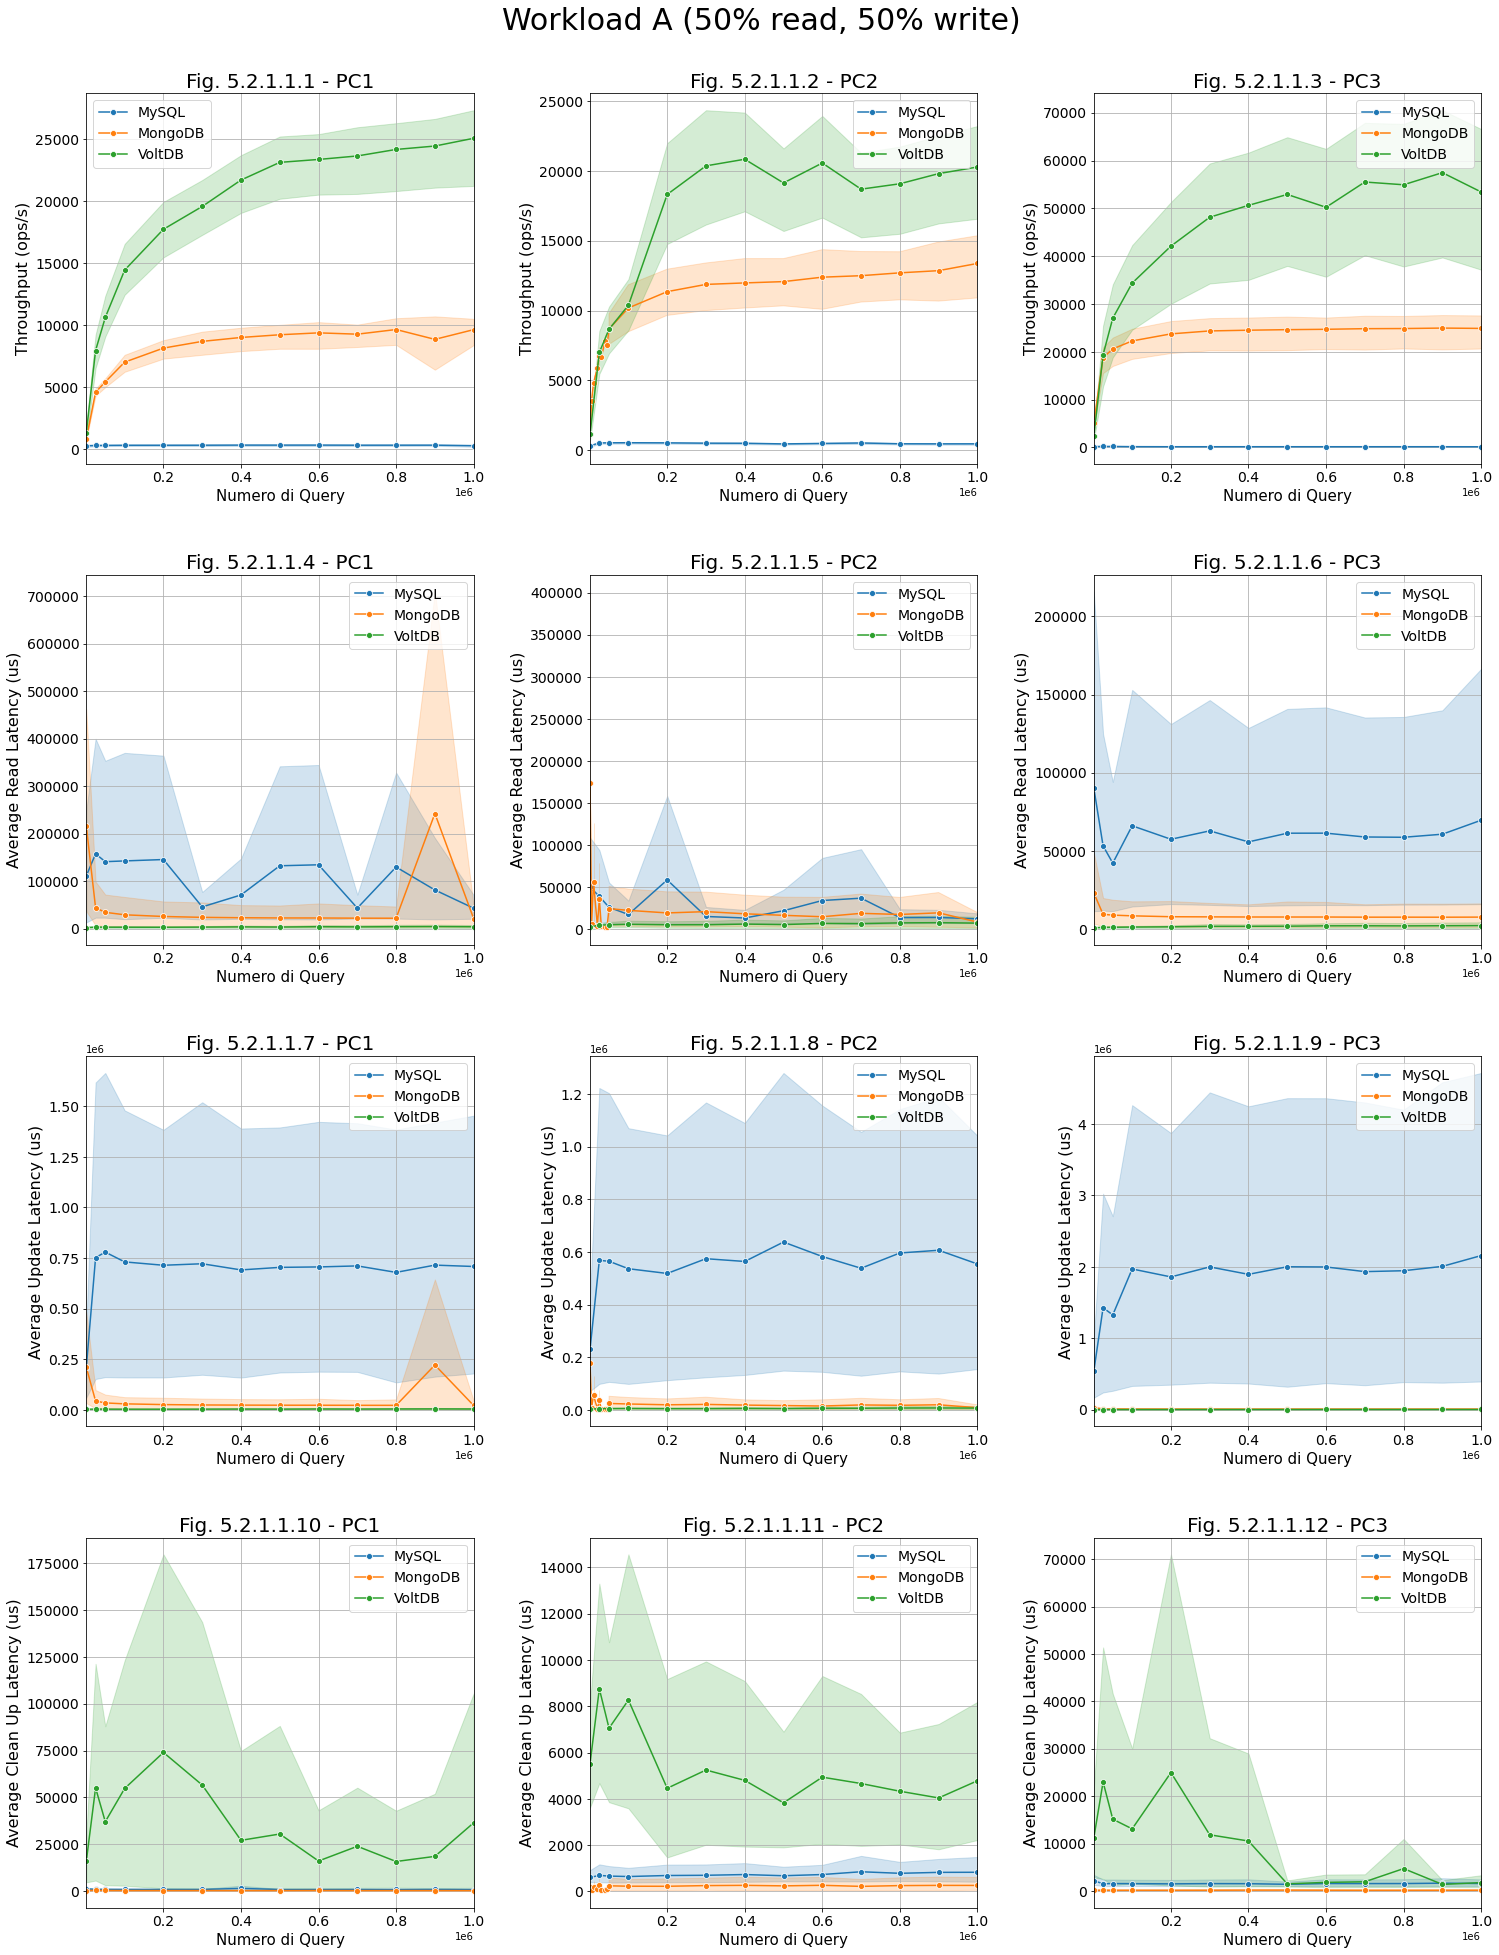

In [ ]:
fig=plt.figure(figsize=(25, 30))
fig.suptitle('Workload A (50% read, 50% write)', fontsize=30)
plt.subplots_adjust(top=0.94, bottom=0.1, wspace=0.3, hspace=0.3)


parametri = ['Throughput (ops/s)', 'Average Read Latency (us)',  'Average Update Latency (us)', 'Average Clean Up Latency (us)']
memoria = [12, 16, 32]
computer = ['PC1', 'PC2', 'PC3']

n_graph = 1

for param in parametri:
    pccount=0
    for ram_dim in memoria:
        x = df['Numero di Query']
        y = df.loc[((df['Database']=='MySQL') & (df['Tipo di Workload']=='a') & (df['Dimensione RAM (GB)']==ram_dim)), param]
        y2 = df.loc[((df['Database']=='MongoDB') & (df['Tipo di Workload']=='a') & (df['Dimensione RAM (GB)']==ram_dim)), param]
        y3 = df.loc[((df['Database']=='VoltDB') & (df['Tipo di Workload']=='a') & (df['Dimensione RAM (GB)']==ram_dim)), param]

        ax = fig.add_subplot(4, 3, n_graph)
        sns.lineplot (x, y, label = 'MySQL', marker = 'o', ax=ax)
        sns.lineplot (x, y2, label = 'MongoDB', marker = 'o', ax=ax)
        sns.lineplot (x, y3, label = 'VoltDB', marker = 'o', ax=ax)
        ax.set_xlim(800, 1000100)
        new_title = 'Fig. 5.2.1.1.' + str(n_graph) +' - ' + computer[pccount]
        ax.set_title(new_title, fontsize=20)
        ax.set_xlabel('Numero di Query', fontsize=15)
        ax.set_ylabel(param, fontsize=16)
        plt.setp(ax.get_xticklabels(), fontsize=14)
        plt.setp(ax.get_yticklabels(), fontsize=14)
        ax.grid()
        ax.legend(prop={'size': 14})
        n_graph+=1
        pccount+=1

plt.show()

#### MySQL tuned

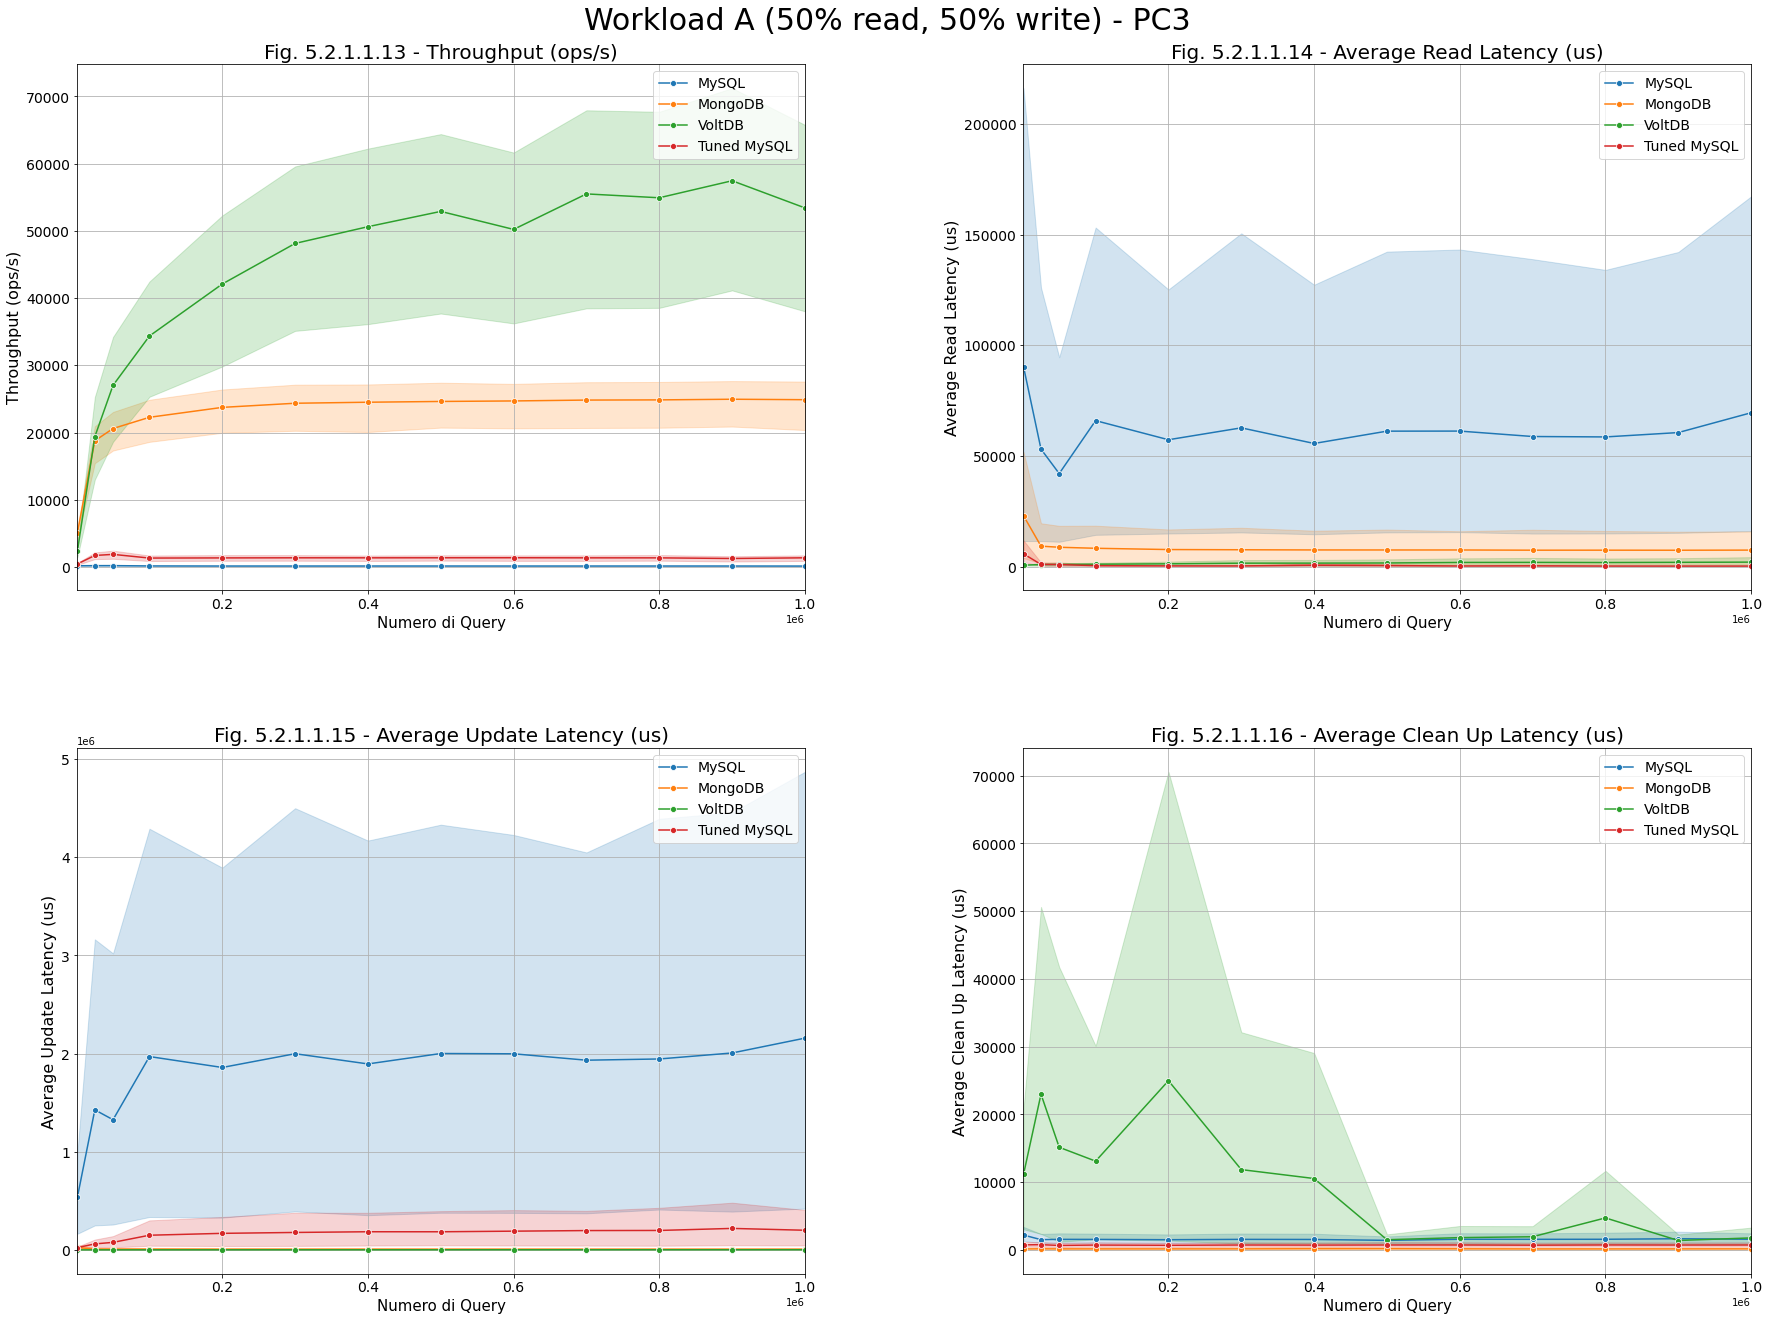

In [ ]:
fig=plt.figure(figsize=(30, 20))
fig.suptitle('Workload A (50% read, 50% write) - PC3', fontsize=30)
plt.subplots_adjust(top=0.94, bottom=0.1, wspace=0.3, hspace=0.3)


parametri = ['Throughput (ops/s)', 'Average Read Latency (us)',  'Average Update Latency (us)', 'Average Clean Up Latency (us)']

n_graph = 1
for param in parametri:
    x = df['Numero di Query']
    y = df.loc[((df['Database']=='MySQL') & (df['Tipo di Workload']=='a') & (df['Dimensione RAM (GB)']==32)), param]
    y2 = df.loc[((df['Database']=='MongoDB') & (df['Tipo di Workload']=='a') & (df['Dimensione RAM (GB)']==32)), param]
    y3 = df.loc[((df['Database']=='VoltDB') & (df['Tipo di Workload']=='a') & (df['Dimensione RAM (GB)']==32)), param]

    y4 = df.loc[((df['Database']=='MySQL (tuned)') & (df['Tipo di Workload']=='a') & (df['Dimensione RAM (GB)']==32)), param]

    ax = fig.add_subplot(2, 2, n_graph)
    sns.lineplot (x, y, label = 'MySQL', marker = 'o', ax=ax)
    sns.lineplot (x, y2, label = 'MongoDB', marker = 'o', ax=ax)
    sns.lineplot (x, y3, label = 'VoltDB', marker = 'o', ax=ax)

    sns.lineplot (x, y4, label = 'Tuned MySQL', marker = 'o', ax=ax)
#        ax = plt.gca()
    ax.set_xlim(800, 1000100)
#        new_title = param + ' per n° di operazioni - RAM=' + str(ram_dim) + 'GB' + ' CPU=' + str(velocita[cpucount]) + 'gHz'
    new_title = 'Fig. 5.2.1.1.' + str(n_graph+12) + ' - ' + param
    ax.set_title(new_title, fontsize=20)
    ax.set_xlabel('Numero di Query', fontsize=15)
    ax.set_ylabel(param, fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=14)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    ax.grid()
    ax.legend(prop={'size': 14})
    n_graph+=1

plt.show()

### Workload B - 95/5 Query Puntuali

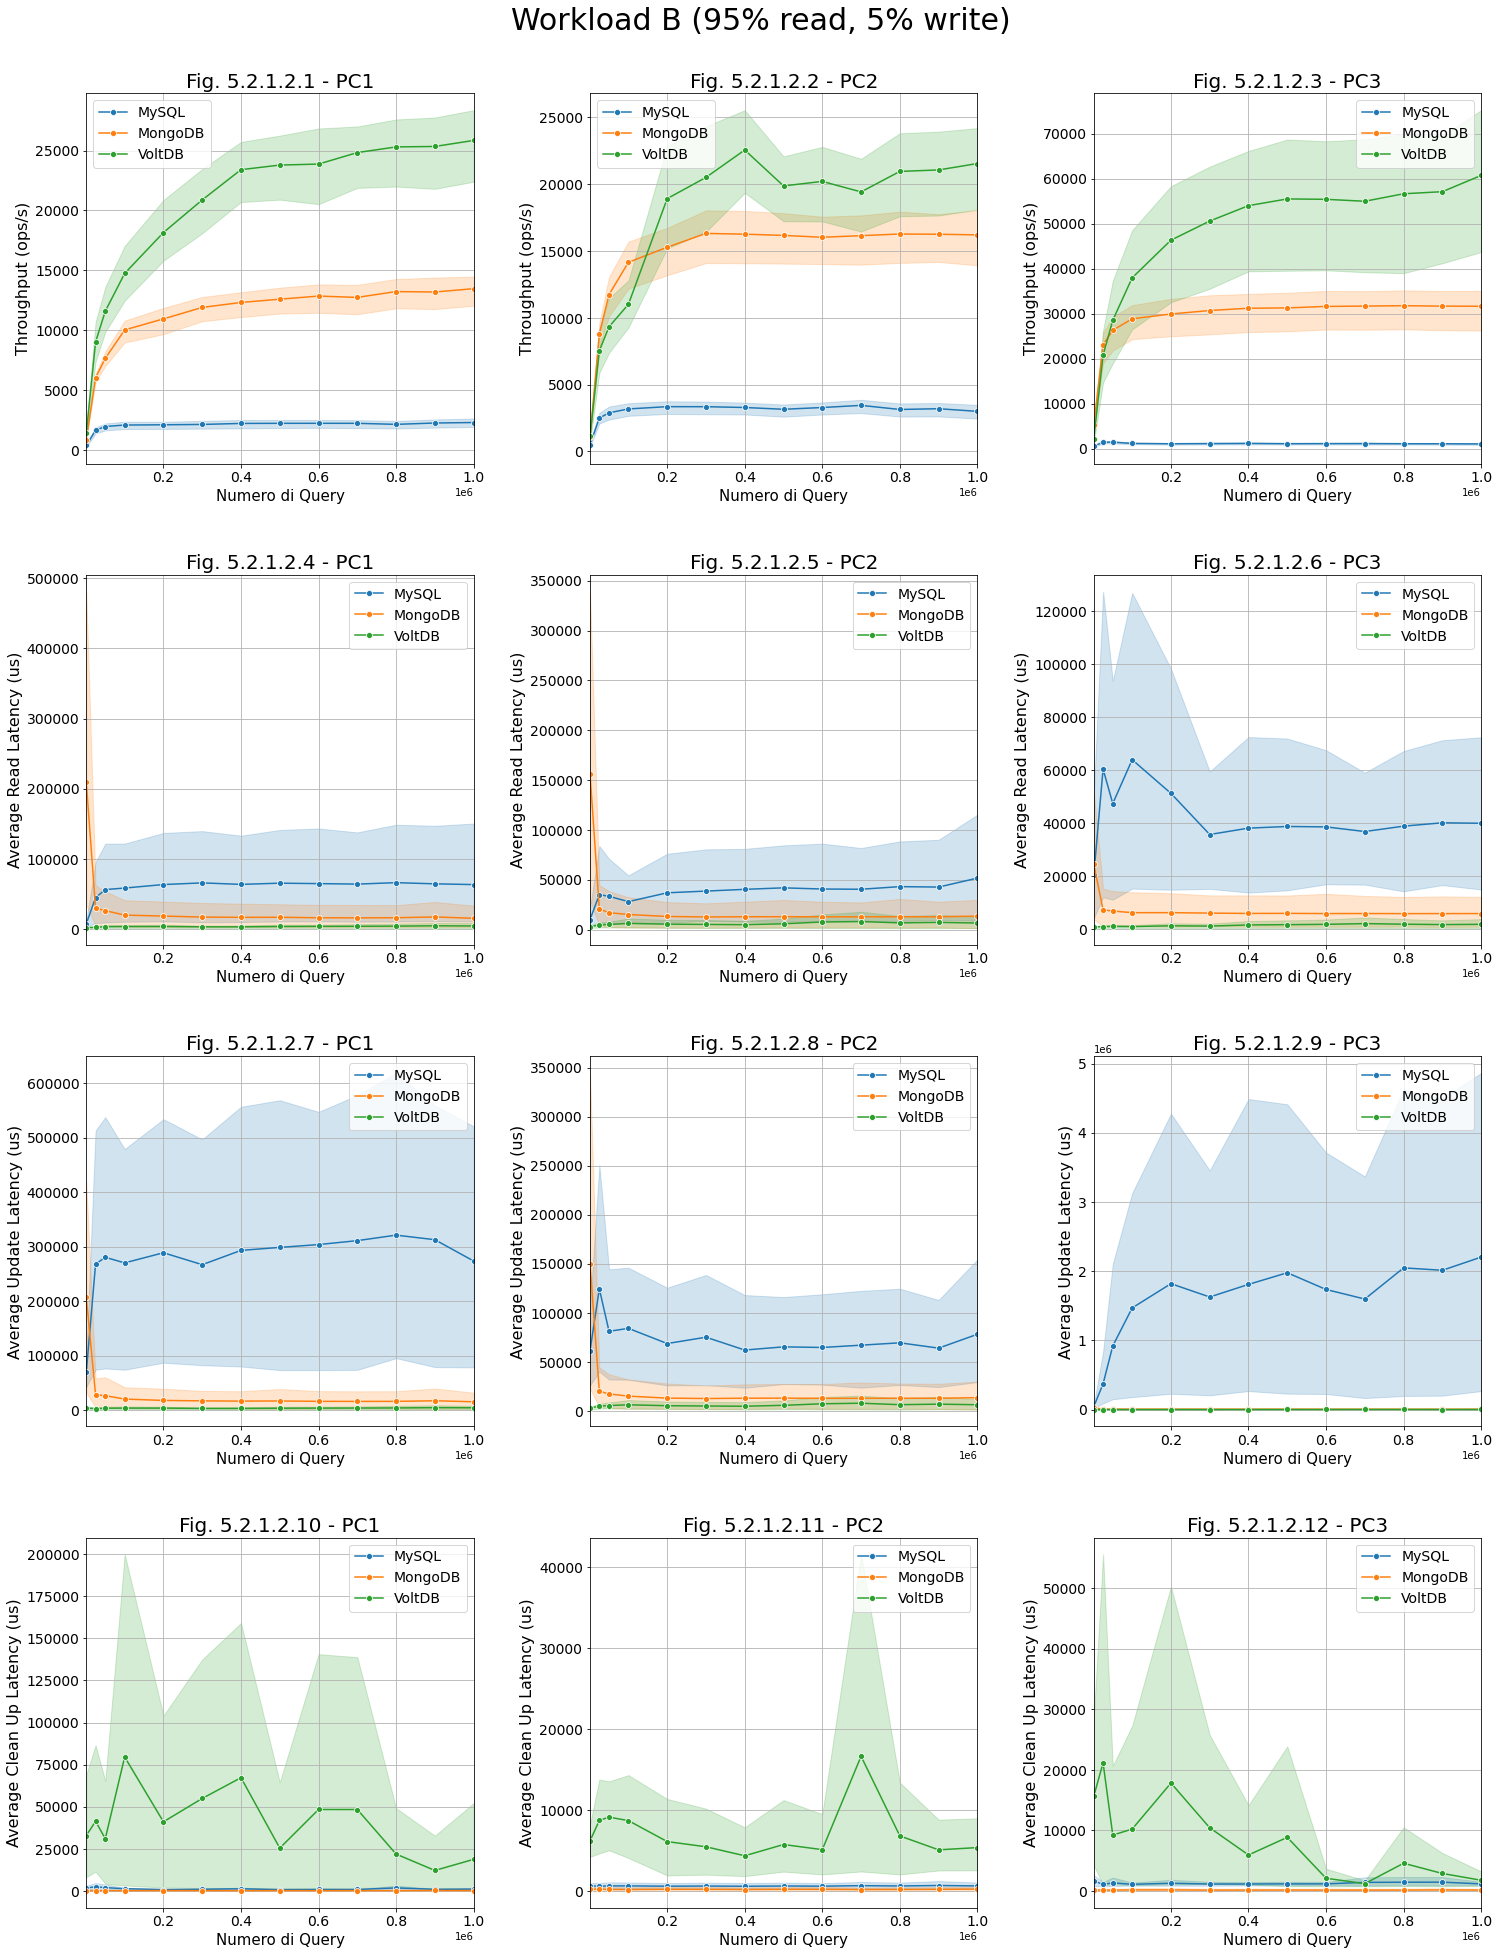

In [ ]:
fig=plt.figure(figsize=(25, 30))
fig.suptitle('Workload B (95% read, 5% write)', fontsize=30)
plt.subplots_adjust(top=0.94, bottom=0.1, wspace=0.3, hspace=0.3)

parametri = ['Throughput (ops/s)', 'Average Read Latency (us)',  'Average Update Latency (us)', 'Average Clean Up Latency (us)']
memoria = [12, 16, 32]
computer = ['PC1', 'PC2', 'PC3']

n_graph = 1

for param in parametri:
    pccount = 0
    for ram_dim in memoria:
        x = df['Numero di Query']
        y = df.loc[((df['Database']=='MySQL') & (df['Tipo di Workload']=='b') & (df['Dimensione RAM (GB)']==ram_dim)), param]
        y2 = df.loc[((df['Database']=='MongoDB') & (df['Tipo di Workload']=='b') & (df['Dimensione RAM (GB)']==ram_dim)), param]
        y3 = df.loc[((df['Database']=='VoltDB') & (df['Tipo di Workload']=='b') & (df['Dimensione RAM (GB)']==ram_dim)), param]
        ax = fig.add_subplot(4, 3, n_graph)
        sns.lineplot (x, y, label = 'MySQL', marker = 'o', ax=ax)
        sns.lineplot (x, y2, label = 'MongoDB', marker = 'o', ax=ax)
        sns.lineplot (x, y3, label = 'VoltDB', marker = 'o', ax=ax)
        ax = plt.gca()
        ax.set_xlim(800, 1000100)
        new_title = 'Fig. 5.2.1.2.' + str(n_graph) +' - ' + computer[pccount]
        ax.set_title(new_title, fontsize=20)
        ax.set_xlabel('Numero di Query', fontsize=15)
        ax.set_ylabel(param, fontsize=16)
        plt.setp(ax.get_xticklabels(), fontsize=14)
        plt.setp(ax.get_yticklabels(), fontsize=14)
        ax.grid()
        ax.legend(prop={'size': 14})
        n_graph+=1
        pccount+=1 
plt.show()

#### MySQL Tuned

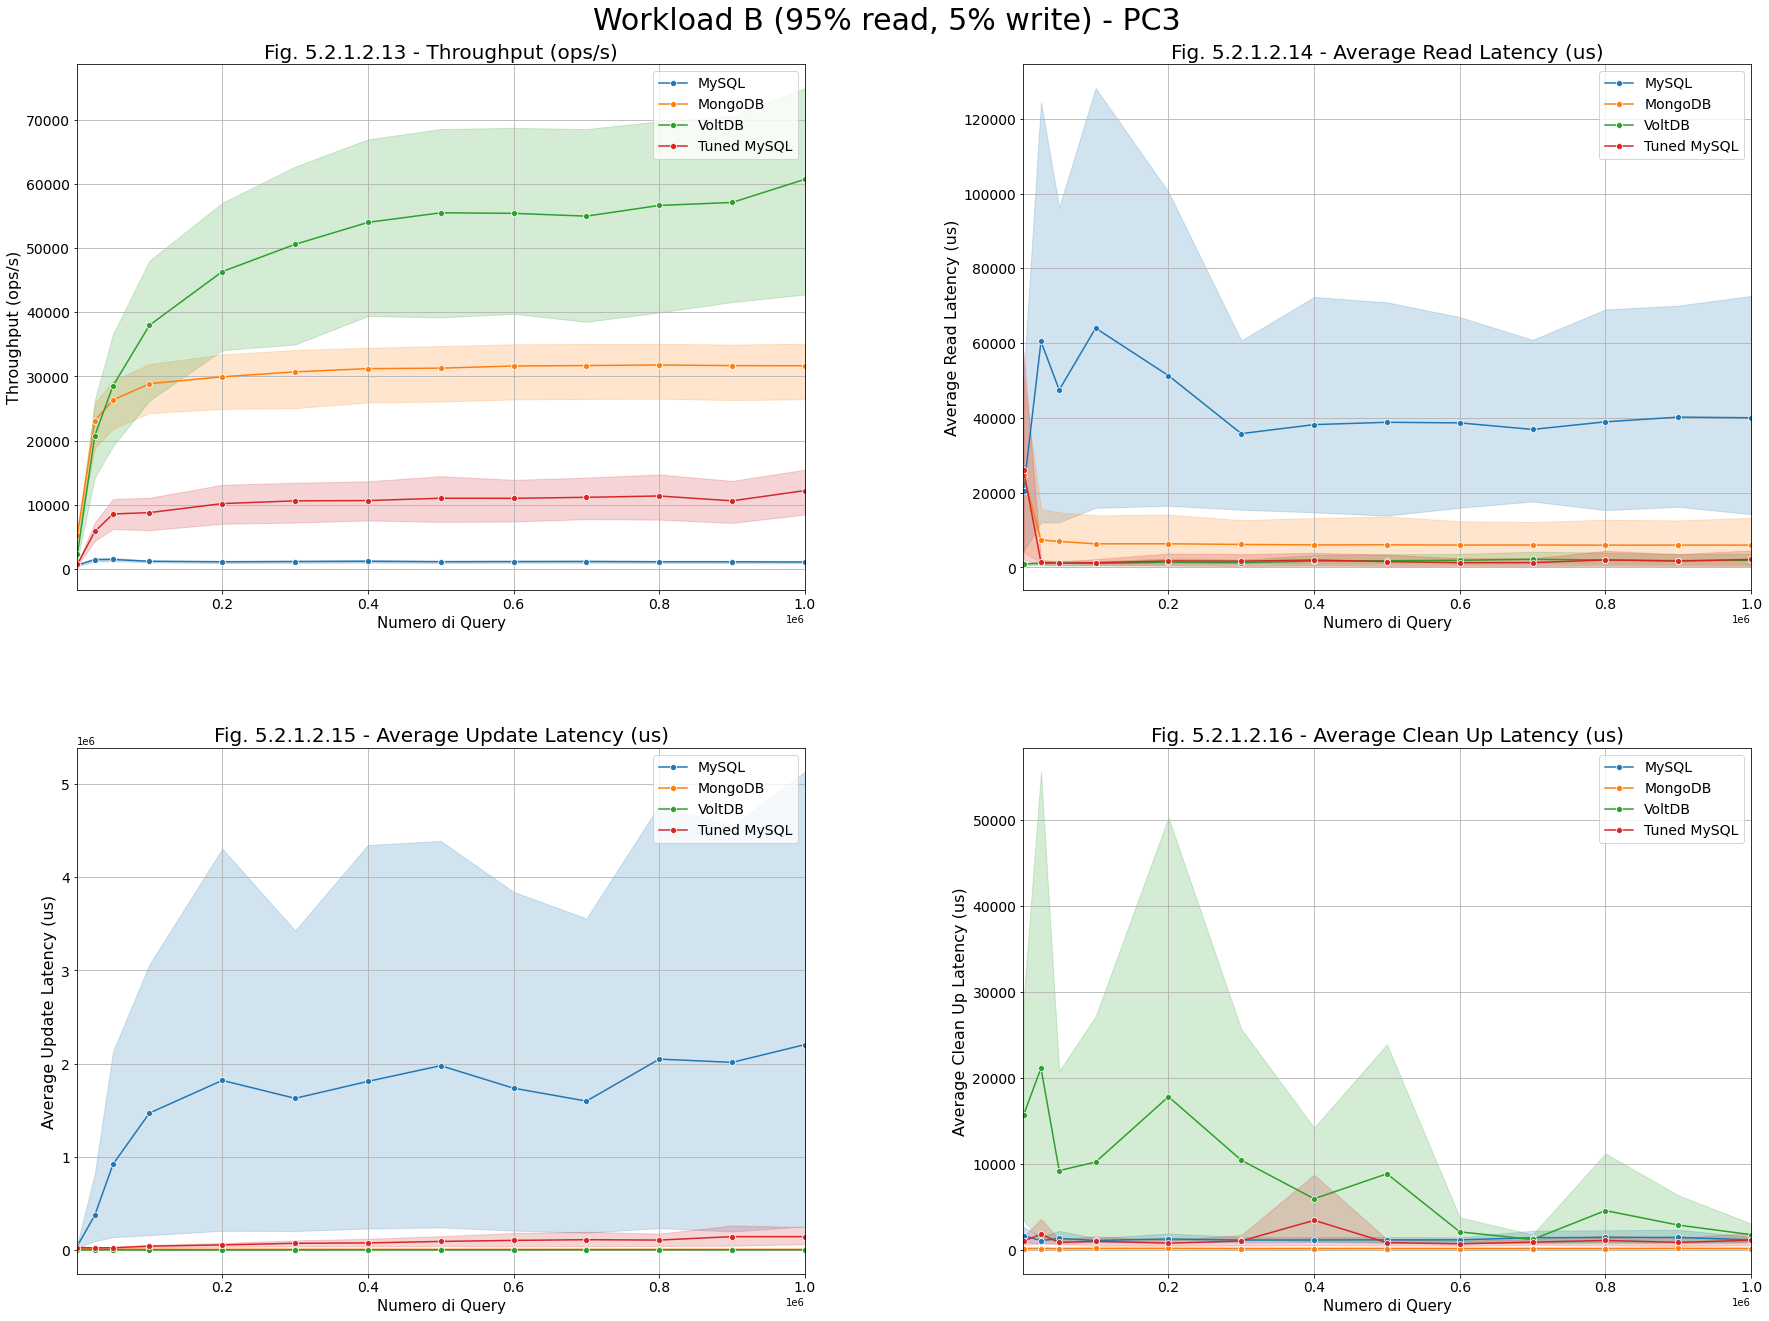

In [ ]:
fig=plt.figure(figsize=(30, 20))
fig.suptitle('Workload B (95% read, 5% write) - PC3', fontsize=30)
plt.subplots_adjust(top=0.94, bottom=0.1, wspace=0.3, hspace=0.3)


parametri = ['Throughput (ops/s)', 'Average Read Latency (us)',  'Average Update Latency (us)', 'Average Clean Up Latency (us)']

n_graph = 1
for param in parametri:
    x = df['Numero di Query']
    y = df.loc[((df['Database']=='MySQL') & (df['Tipo di Workload']=='b') & (df['Dimensione RAM (GB)']==32)), param]
    y2 = df.loc[((df['Database']=='MongoDB') & (df['Tipo di Workload']=='b') & (df['Dimensione RAM (GB)']==32)), param]
    y3 = df.loc[((df['Database']=='VoltDB') & (df['Tipo di Workload']=='b') & (df['Dimensione RAM (GB)']==32)), param]
    y4 = df.loc[((df['Database']=='MySQL (tuned)') & (df['Tipo di Workload']=='b') & (df['Dimensione RAM (GB)']==32)), param]

    ax = fig.add_subplot(2, 2, n_graph)
    sns.lineplot (x, y, label = 'MySQL', marker = 'o', ax=ax)
    sns.lineplot (x, y2, label = 'MongoDB', marker = 'o', ax=ax)
    sns.lineplot (x, y3, label = 'VoltDB', marker = 'o', ax=ax)
    sns.lineplot (x, y4, label = 'Tuned MySQL', marker = 'o', ax=ax)

    ax.set_xlim(800, 1000100)
    new_title = 'Fig. 5.2.1.2.' + str(n_graph+12) + ' - ' + param
    ax.set_title(new_title, fontsize=20)
    ax.set_xlabel('Numero di Query', fontsize=15)
    ax.set_ylabel(param, fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=14)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    ax.grid()
    ax.legend(prop={'size': 14})
    n_graph+=1

plt.show()

### Workload E - 100 Ranged query

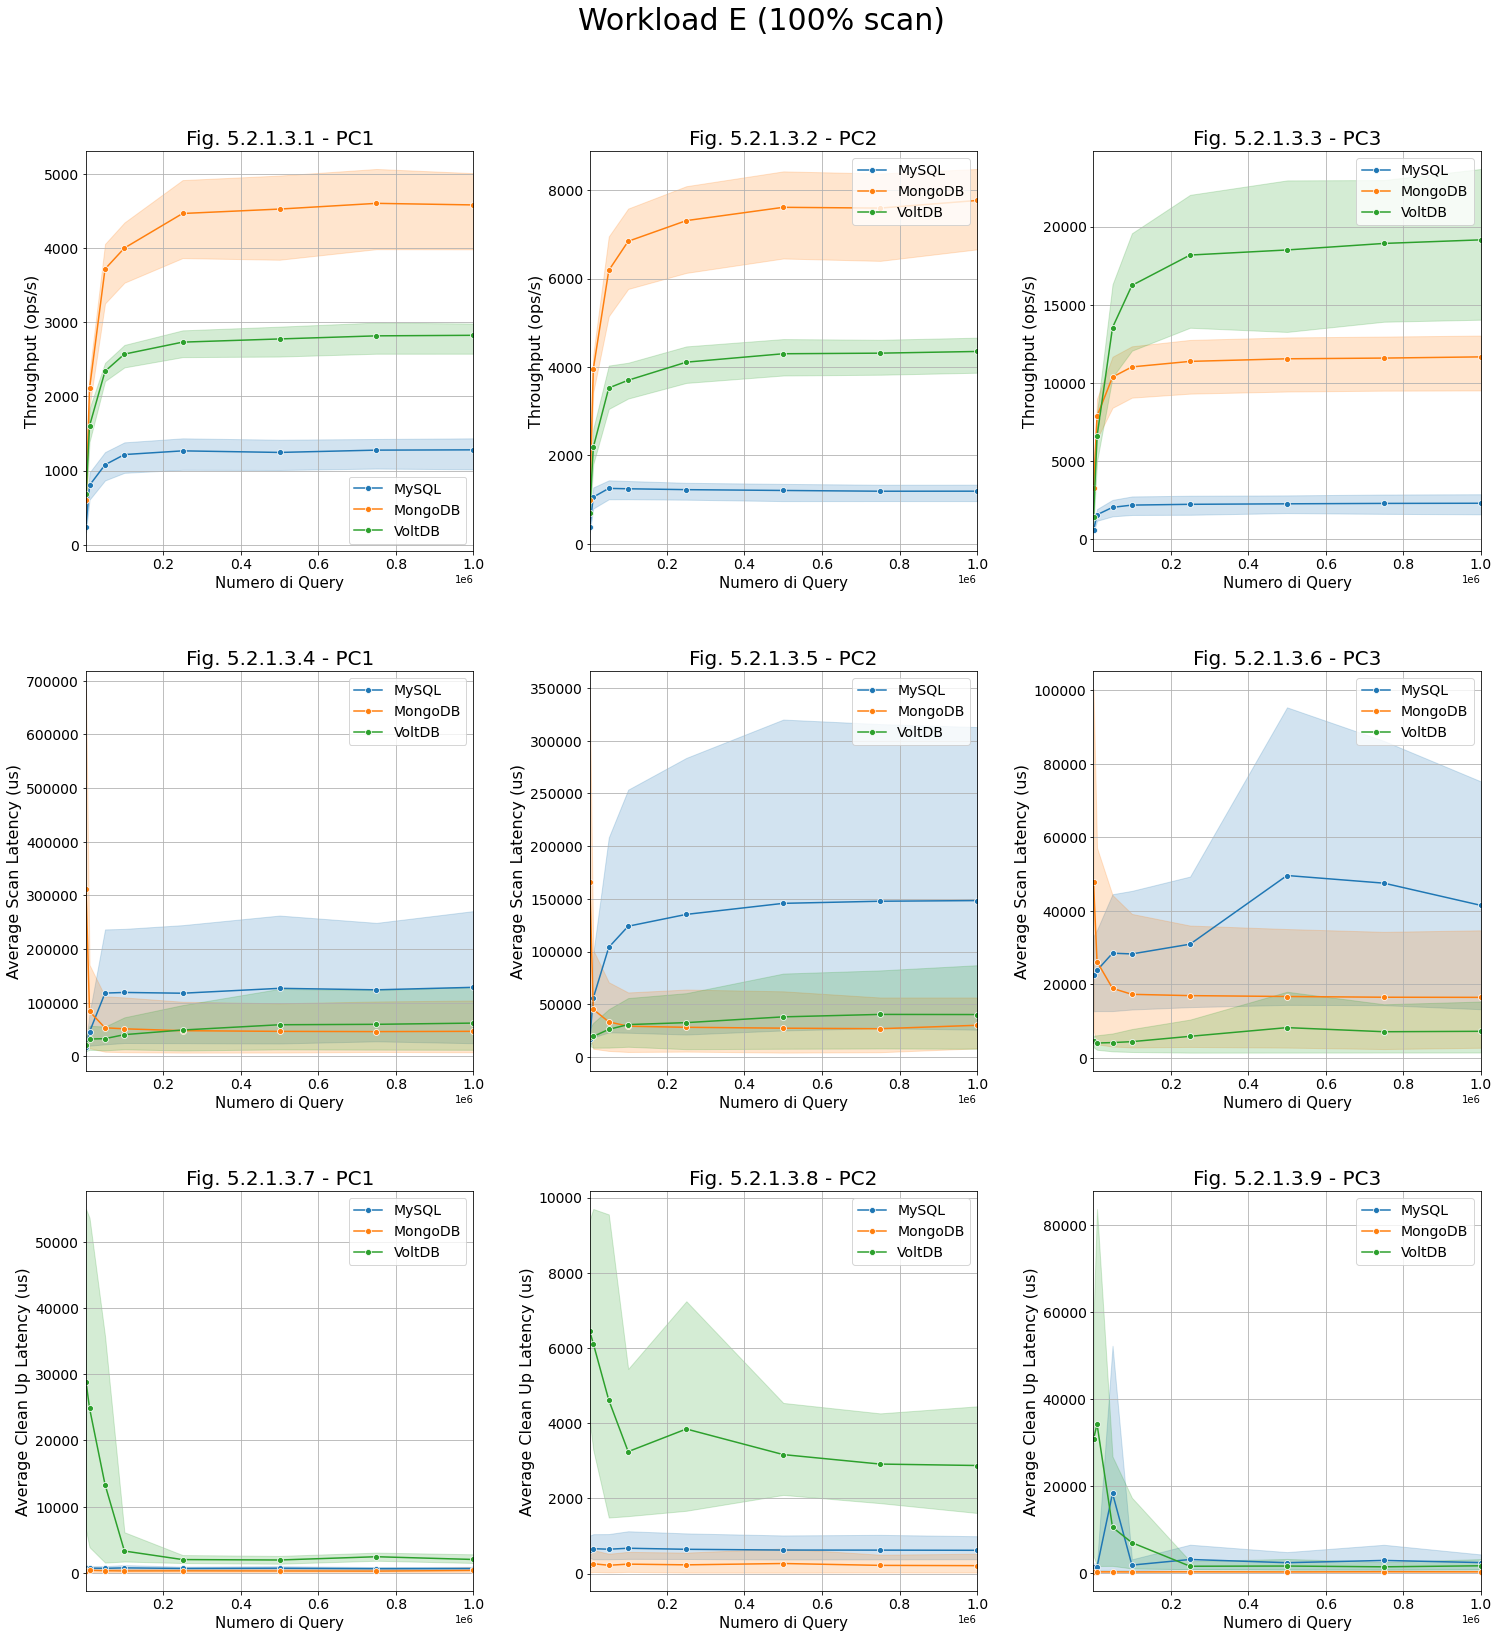

In [18]:
# Throughhput per numero di operazioni con 10 threads
fig=plt.figure(figsize=(25, 25))
fig.suptitle('Workload E (100% scan)', fontsize=30)
plt.subplots_adjust(top=0.9, bottom=0.1, wspace=0.3, hspace=0.3)


parametri = ['Throughput (ops/s)', 'Average Scan Latency (us)', 'Average Clean Up Latency (us)']
memoria = [12, 16, 32]
computer = ['PC1', 'PC2', 'PC3']

n_graph = 1

for param in parametri:
    pccount=0
    for ram_dim in memoria:
        x = df['Numero di Query']
        if ram_dim == 12:
            y = df.loc[((df['Database']=='MySQL (new)') & (df['Tipo di Workload']=='e') & (df['Dimensione RAM (GB)']==ram_dim)), param]
            y2 = df.loc[((df['Database']=='MongoDB (new)') & (df['Tipo di Workload']=='e') & (df['Dimensione RAM (GB)']==ram_dim)), param]
        else:
            y = df.loc[((df['Database']=='MySQL') & (df['Tipo di Workload']=='e') & (df['Dimensione RAM (GB)']==ram_dim)), param]
            y2 = df.loc[((df['Database']=='MongoDB') & (df['Tipo di Workload']=='e') & (df['Dimensione RAM (GB)']==ram_dim)), param]
        y3 = df.loc[((df['Database']=='VoltDB') & (df['Tipo di Workload']=='e') & (df['Dimensione RAM (GB)']==ram_dim)), param]
        ax = fig.add_subplot(3, 3, n_graph)
        sns.lineplot (x, y, label = 'MySQL', marker = 'o', ax=ax)
        sns.lineplot (x, y2, label = 'MongoDB', marker = 'o', ax=ax)
        sns.lineplot (x, y3, label = 'VoltDB', marker = 'o', ax=ax)
        ax = plt.gca()
        ax.set_xlim(800, 1000100)
        new_title = 'Fig. 5.2.1.3.' + str(n_graph) +' - ' + computer[pccount]
        ax.set_title(new_title, fontsize=20)
        ax.set_xlabel('Numero di Query', fontsize=15)
        ax.set_ylabel(param, fontsize=16)
        plt.setp(ax.get_xticklabels(), fontsize=14)
        plt.setp(ax.get_yticklabels(), fontsize=14)
        ax.grid()
        ax.legend(prop={'size': 14})
        n_graph+=1
        pccount+=1
plt.show()

#### MySQL Tuned

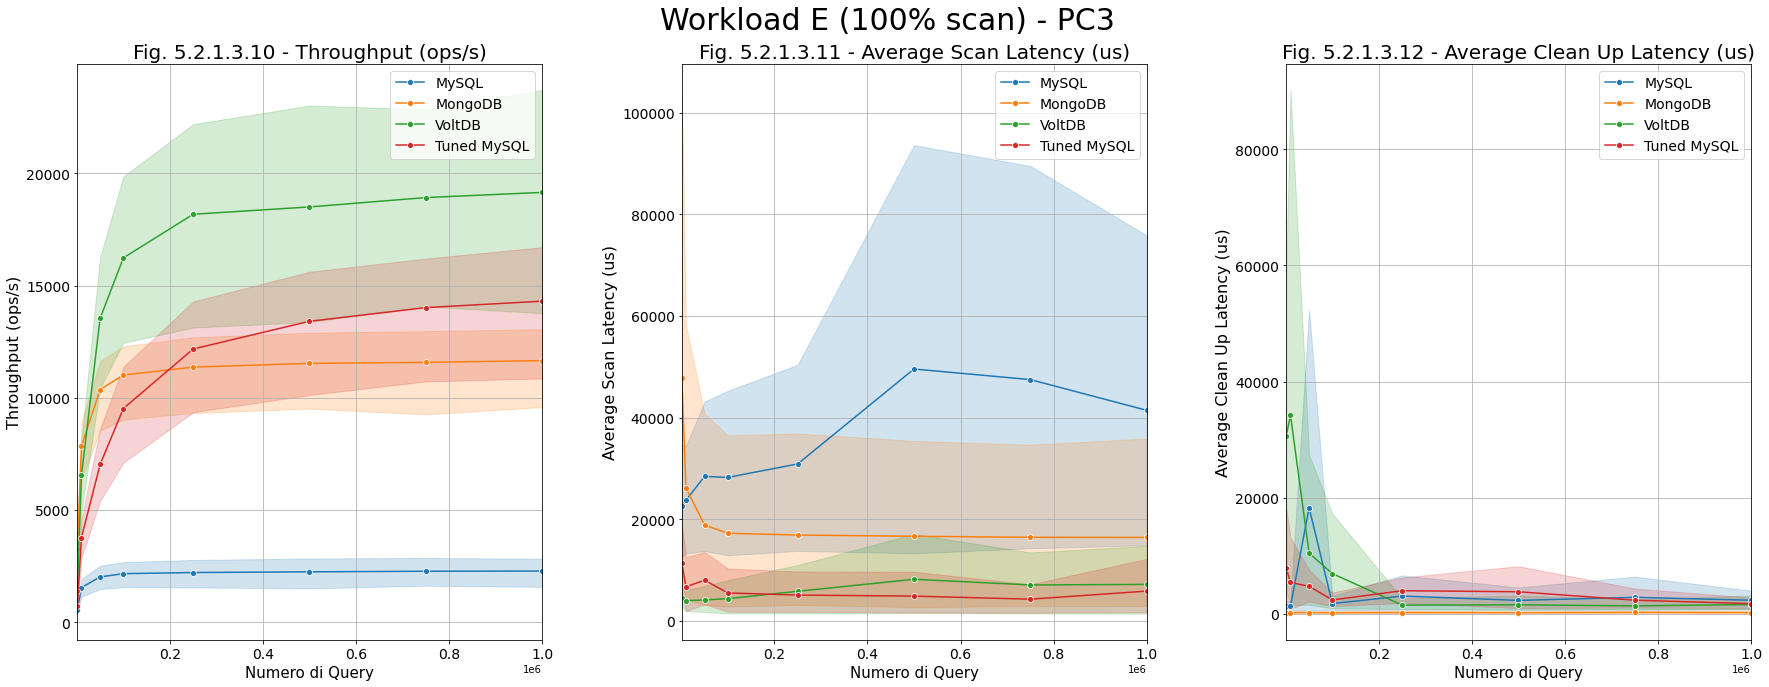

In [ ]:
fig=plt.figure(figsize=(30, 10))
fig.suptitle('Workload E (100% scan) - PC3', fontsize=30)
plt.subplots_adjust(top=0.9, bottom=0.1, wspace=0.3, hspace=0.3)


parametri = ['Throughput (ops/s)', 'Average Scan Latency (us)', 'Average Clean Up Latency (us)']


n_graph = 1
for param in parametri:
    x = df['Numero di Query']
    y = df.loc[((df['Database']=='MySQL') & (df['Tipo di Workload']=='e') & (df['Dimensione RAM (GB)']==32)), param]
    y2 = df.loc[((df['Database']=='MongoDB') & (df['Tipo di Workload']=='e') & (df['Dimensione RAM (GB)']==32)), param]
    y3 = df.loc[((df['Database']=='VoltDB') & (df['Tipo di Workload']=='e') & (df['Dimensione RAM (GB)']==32)), param]
    y4 = df.loc[((df['Database']=='MySQL (tuned)') & (df['Tipo di Workload']=='e') & (df['Dimensione RAM (GB)']==32)), param]

    ax = fig.add_subplot(1, 3, n_graph)
    sns.lineplot (x, y, label = 'MySQL', marker = 'o', ax=ax)
    sns.lineplot (x, y2, label = 'MongoDB', marker = 'o', ax=ax)
    sns.lineplot (x, y3, label = 'VoltDB', marker = 'o', ax=ax)
    sns.lineplot (x, y4, label = 'Tuned MySQL', marker = 'o', ax=ax)

    ax = plt.gca()
    ax.set_xlim(800, 1000100)
    new_title = 'Fig. 5.2.1.3.' + str(9+n_graph) +' - ' + param
    ax.set_title(new_title, fontsize=20)
    ax.set_xlabel('Numero di Query', fontsize=15)
    ax.set_ylabel(param, fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=14)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    ax.grid()
    ax.legend(prop={'size': 14})
    n_graph+=1

# Combine all the operations and display
plt.show()

## Latency & throughput in base al numero di thread

### Worload A

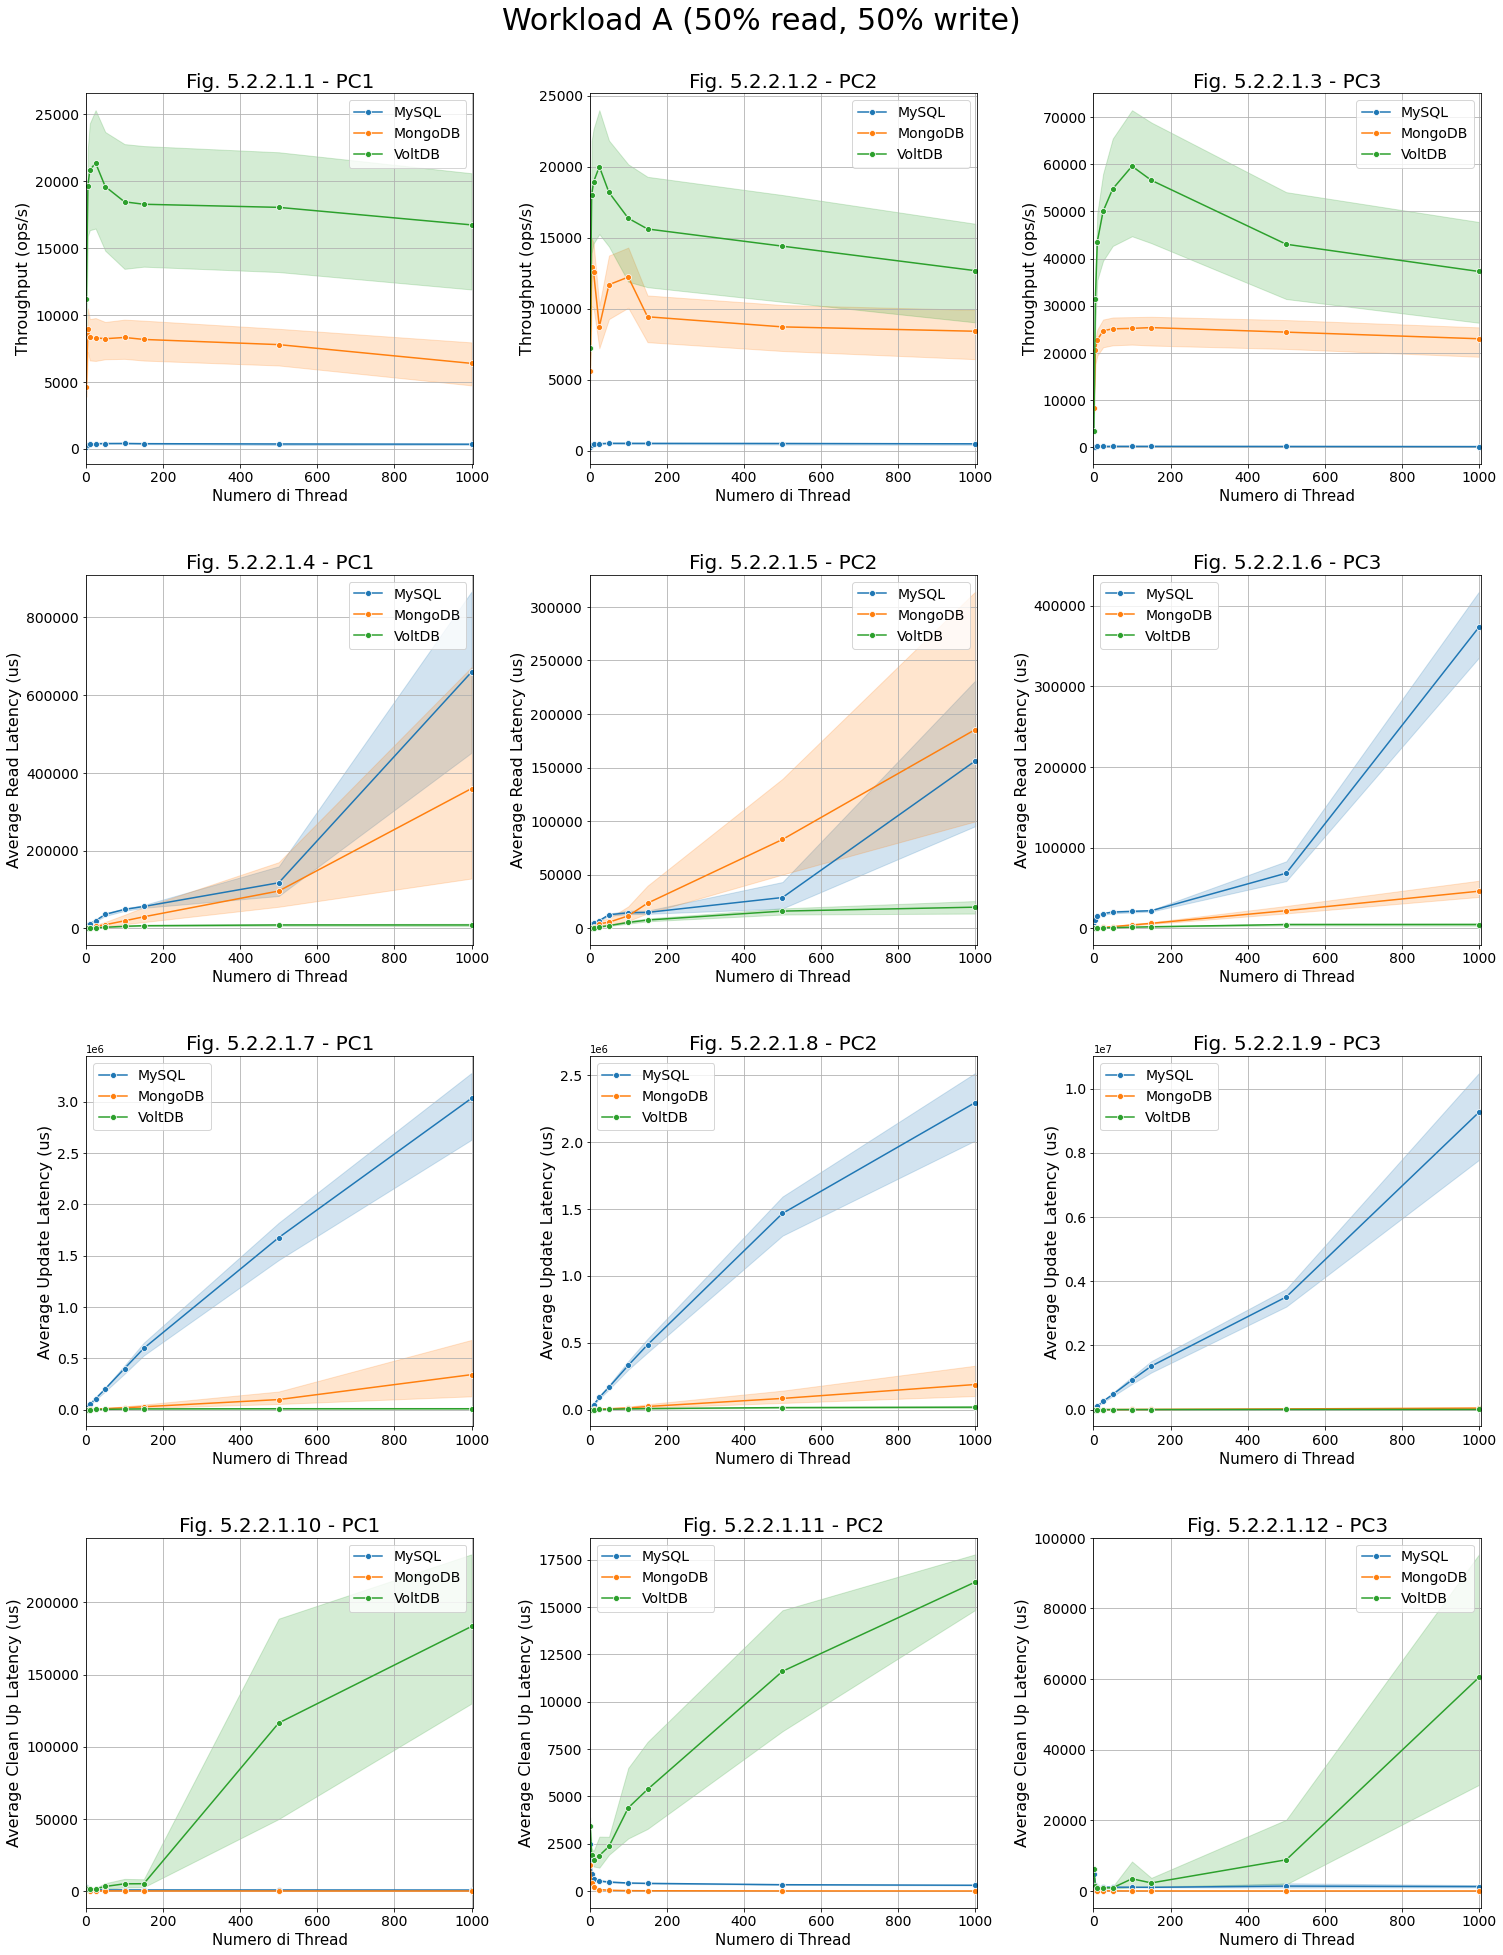

In [ ]:
fig=plt.figure(figsize=(25, 30))
fig.suptitle('Workload A (50% read, 50% write)', fontsize=30)
plt.subplots_adjust(top=0.94, bottom=0.1, wspace=0.3, hspace=0.3)


parametri = ['Throughput (ops/s)', 'Average Read Latency (us)',  'Average Update Latency (us)', 'Average Clean Up Latency (us)']
memoria = [12, 16, 32]
computer = ['PC1', 'PC2', 'PC3']

n_graph = 1

for param in parametri:
    pccount=0
    for ram_dim in memoria:
        x = df['Numero di Thread']
        y = df.loc[((df['Database']=='MySQL') & (df['Tipo di Workload']=='a') & (df['Dimensione RAM (GB)']==ram_dim)), param]
        y2 = df.loc[((df['Database']=='MongoDB') & (df['Tipo di Workload']=='a') & (df['Dimensione RAM (GB)']==ram_dim)), param]
        y3 = df.loc[((df['Database']=='VoltDB') & (df['Tipo di Workload']=='a') & (df['Dimensione RAM (GB)']==ram_dim)), param]
        ax = fig.add_subplot(4, 3, n_graph)
        sns.lineplot (x, y, label = 'MySQL', marker = 'o', ax=ax)
        sns.lineplot (x, y2, label = 'MongoDB', marker = 'o', ax=ax)
        sns.lineplot (x, y3, label = 'VoltDB', marker = 'o', ax=ax)
        ax = plt.gca()
        ax.set_xlim(0, 1005)
        new_title = 'Fig. 5.2.2.1.' + str(n_graph) +' - ' + computer[pccount]
        ax.set_title(new_title, fontsize=20)
        ax.set_xlabel('Numero di Thread', fontsize=15)
        ax.set_ylabel(param, fontsize=16)
        plt.setp(ax.get_xticklabels(), fontsize=14)
        plt.setp(ax.get_yticklabels(), fontsize=14)
        ax.grid()
        ax.legend(prop={'size': 14})
        n_graph+=1
        pccount+=1
plt.show()

#### MySQL Tuned

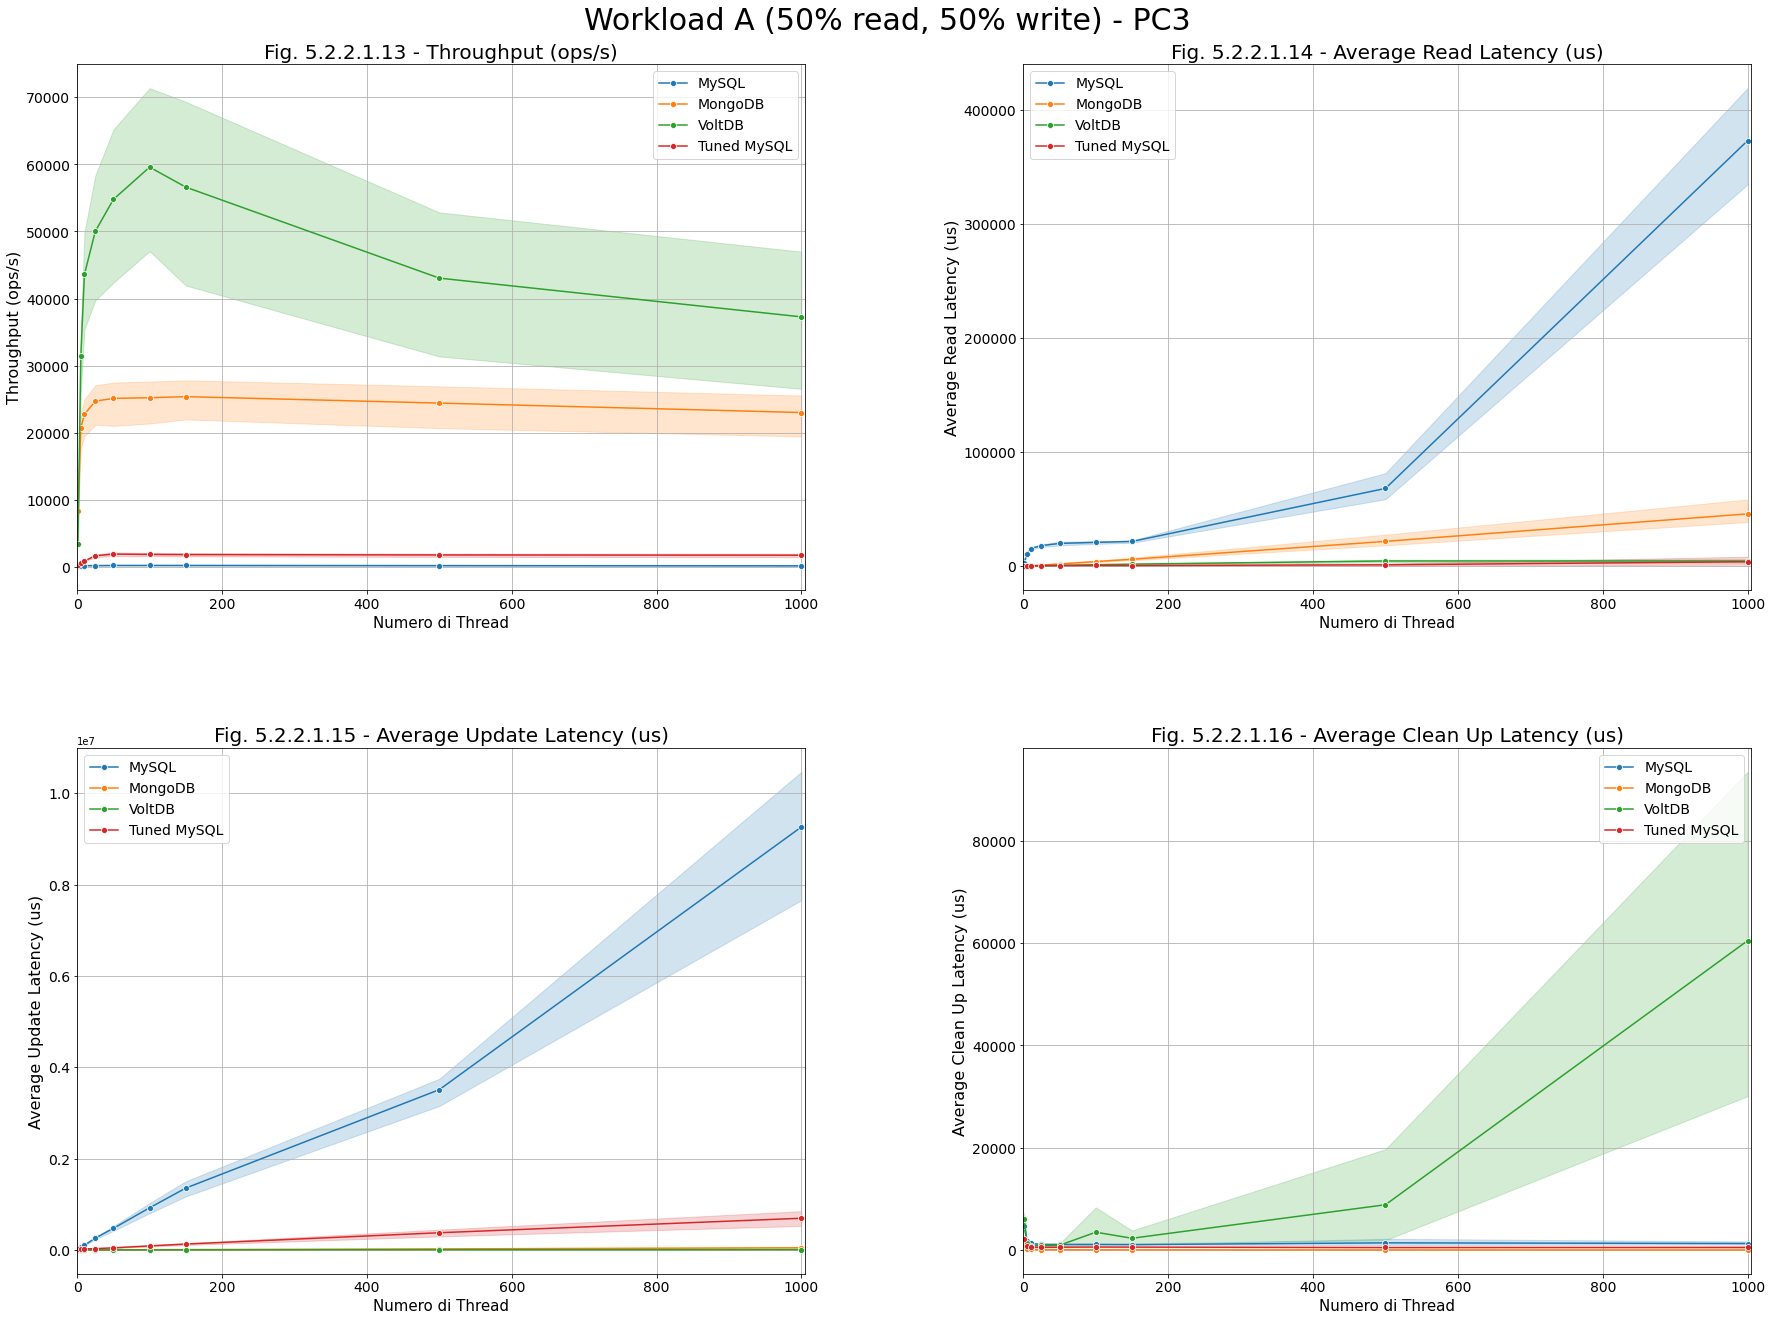

In [ ]:
fig=plt.figure(figsize=(30, 20))
fig.suptitle('Workload A (50% read, 50% write) - PC3', fontsize=30)
plt.subplots_adjust(top=0.94, bottom=0.1, wspace=0.3, hspace=0.3)


parametri = ['Throughput (ops/s)', 'Average Read Latency (us)',  'Average Update Latency (us)', 'Average Clean Up Latency (us)']

n_graph = 1
for param in parametri:
    x = df['Numero di Thread']
    y = df.loc[((df['Database']=='MySQL') & (df['Tipo di Workload']=='a') & (df['Dimensione RAM (GB)']==32)), param]
    y2 = df.loc[((df['Database']=='MongoDB') & (df['Tipo di Workload']=='a') & (df['Dimensione RAM (GB)']==32)), param]
    y3 = df.loc[((df['Database']=='VoltDB') & (df['Tipo di Workload']=='a') & (df['Dimensione RAM (GB)']==32)), param]
    y4 = df.loc[((df['Database']=='MySQL (tuned)') & (df['Tipo di Workload']=='a') & (df['Dimensione RAM (GB)']==32)), param]

    ax = fig.add_subplot(2, 2, n_graph)
    sns.lineplot (x, y, label = 'MySQL', marker = 'o', ax=ax)
    sns.lineplot (x, y2, label = 'MongoDB', marker = 'o', ax=ax)
    sns.lineplot (x, y3, label = 'VoltDB', marker = 'o', ax=ax)
    sns.lineplot (x, y4, label = 'Tuned MySQL', marker = 'o', ax=ax)

    ax.set_xlim(0, 1005)
    new_title = 'Fig. 5.2.2.1.' + str(n_graph+12) + ' - ' + param
    ax.set_title(new_title, fontsize=20)
    ax.set_xlabel('Numero di Thread', fontsize=15)
    ax.set_ylabel(param, fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=14)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    ax.grid()
    ax.legend(prop={'size': 14})
    n_graph+=1

plt.show()

### Workload B

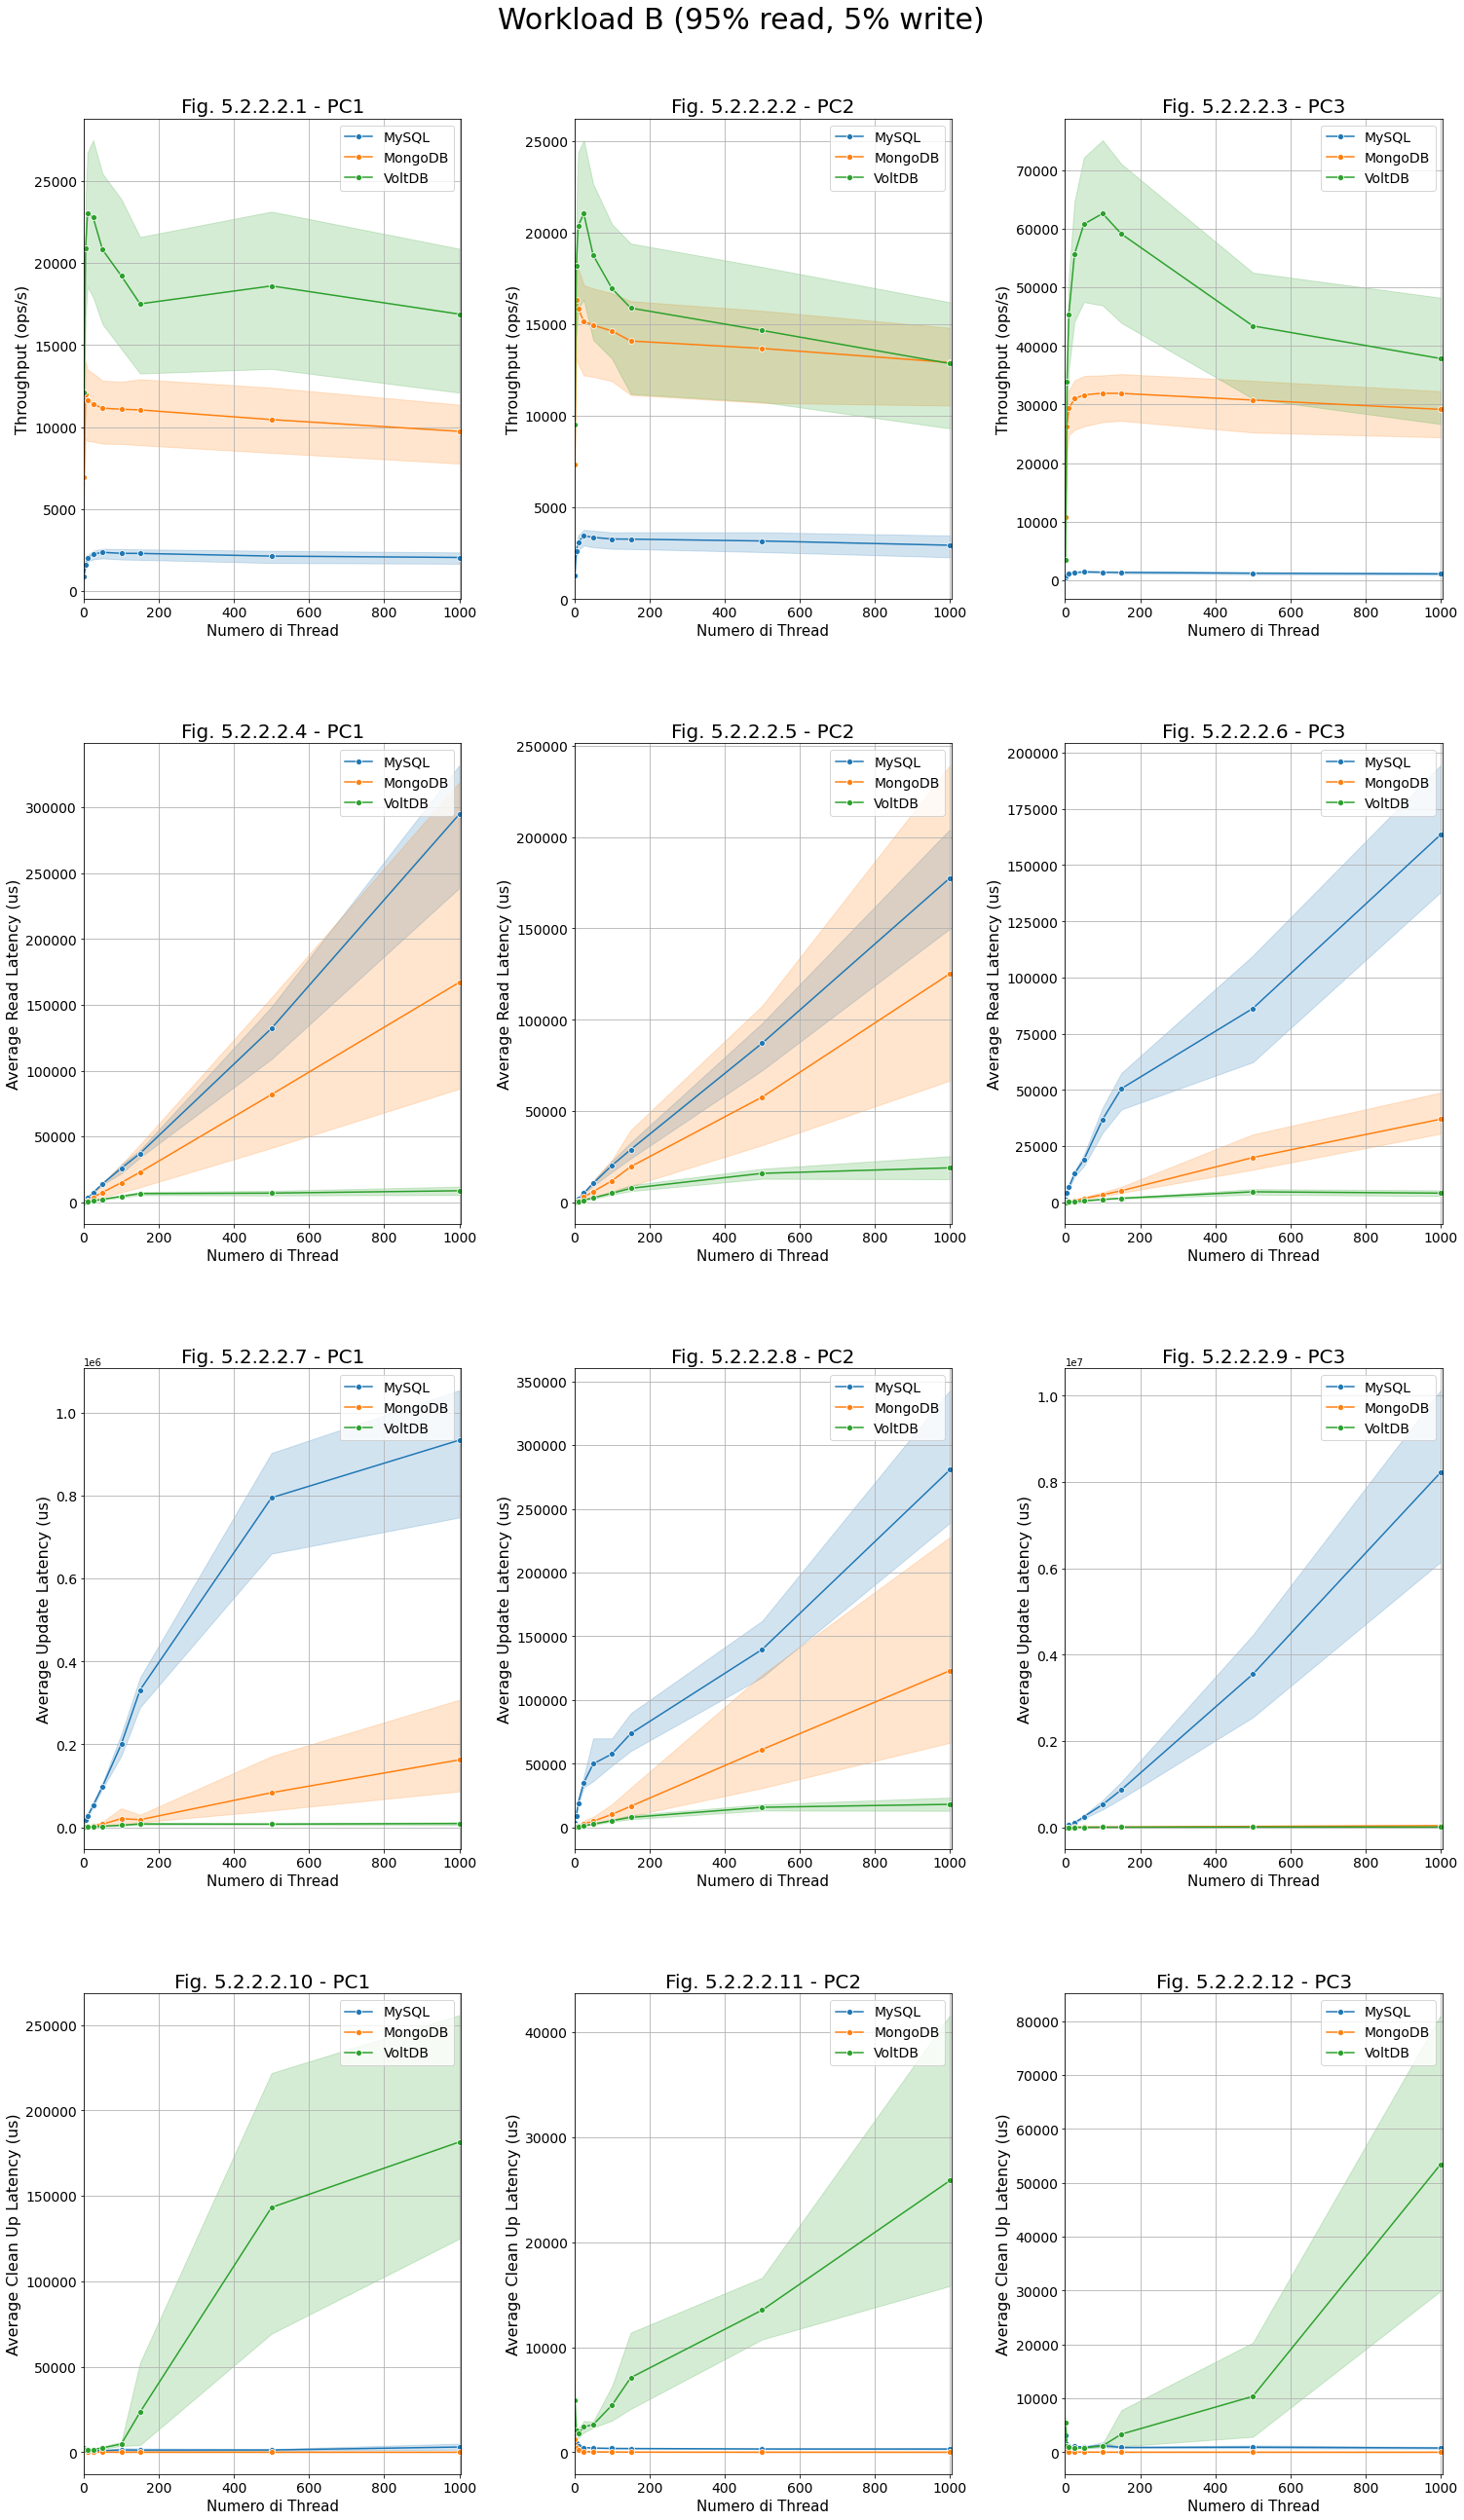

In [ ]:
fig=plt.figure(figsize=(25, 40))
fig.suptitle('Workload B (95% read, 5% write)', fontsize=30)
plt.subplots_adjust(top=0.94, bottom=0.1, wspace=0.3, hspace=0.3)

parametri = ['Throughput (ops/s)', 'Average Read Latency (us)',  'Average Update Latency (us)', 'Average Clean Up Latency (us)']
memoria = [12, 16, 32]
computer = ['PC1', 'PC2', 'PC3']

n_graph = 1

for param in parametri:
    pccount=0
    for ram_dim in memoria:
        x = df['Numero di Thread']
        y = df.loc[((df['Database']=='MySQL') & (df['Tipo di Workload']=='b') & (df['Dimensione RAM (GB)']==ram_dim)), param]
        y2 = df.loc[((df['Database']=='MongoDB') & (df['Tipo di Workload']=='b') & (df['Dimensione RAM (GB)']==ram_dim)), param]
        y3 = df.loc[((df['Database']=='VoltDB') & (df['Tipo di Workload']=='b') & (df['Dimensione RAM (GB)']==ram_dim)), param]
        ax = fig.add_subplot(4, 3, n_graph)
        sns.lineplot (x, y, label = 'MySQL', marker = 'o', ax=ax)
        sns.lineplot (x, y2, label = 'MongoDB', marker = 'o', ax=ax)
        sns.lineplot (x, y3, label = 'VoltDB', marker = 'o', ax=ax)
        ax = plt.gca()
        ax.set_xlim(0, 1005)
        new_title = 'Fig. 5.2.2.2.' + str(n_graph) +' - ' + computer[pccount]
        ax.set_title(new_title, fontsize=20)
        ax.set_xlabel('Numero di Thread', fontsize=15)
        ax.set_ylabel(param, fontsize=16)
        plt.setp(ax.get_xticklabels(), fontsize=14)
        plt.setp(ax.get_yticklabels(), fontsize=14)
        ax.grid()
        ax.legend(prop={'size': 14})
        n_graph+=1
        pccount+=1
plt.show()

#### MySQL Tuned

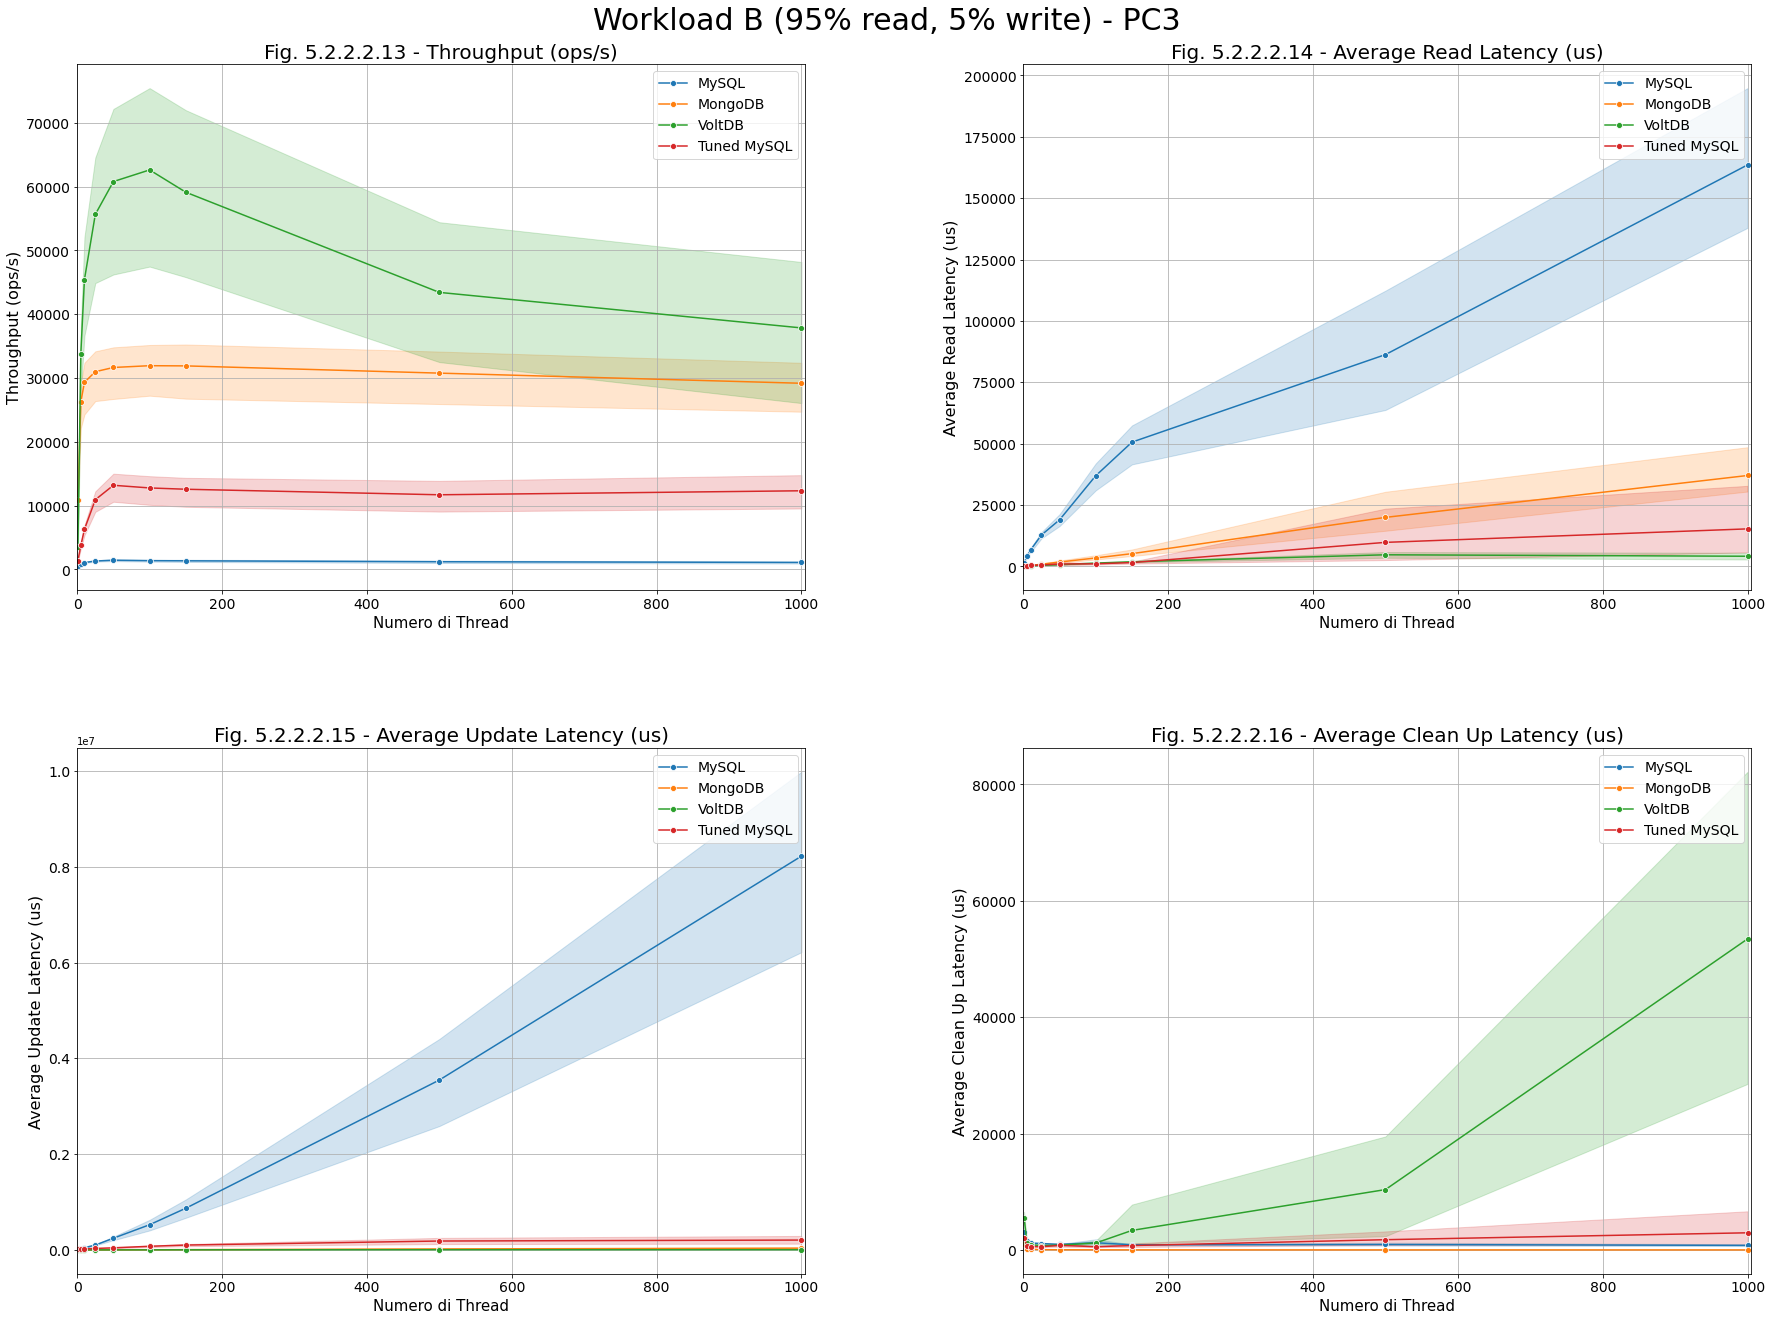

In [ ]:
fig=plt.figure(figsize=(30, 20))
fig.suptitle('Workload B (95% read, 5% write) - PC3', fontsize=30)
plt.subplots_adjust(top=0.94, bottom=0.1, wspace=0.3, hspace=0.3)


parametri = ['Throughput (ops/s)', 'Average Read Latency (us)',  'Average Update Latency (us)', 'Average Clean Up Latency (us)']

n_graph = 1
for param in parametri:
    x = df['Numero di Thread']
    y = df.loc[((df['Database']=='MySQL') & (df['Tipo di Workload']=='b') & (df['Dimensione RAM (GB)']==32)), param]
    y2 = df.loc[((df['Database']=='MongoDB') & (df['Tipo di Workload']=='b') & (df['Dimensione RAM (GB)']==32)), param]
    y3 = df.loc[((df['Database']=='VoltDB') & (df['Tipo di Workload']=='b') & (df['Dimensione RAM (GB)']==32)), param]
    y4 = df.loc[((df['Database']=='MySQL (tuned)') & (df['Tipo di Workload']=='b') & (df['Dimensione RAM (GB)']==32)), param]

    ax = fig.add_subplot(2, 2, n_graph)
    sns.lineplot (x, y, label = 'MySQL', marker = 'o', ax=ax)
    sns.lineplot (x, y2, label = 'MongoDB', marker = 'o', ax=ax)
    sns.lineplot (x, y3, label = 'VoltDB', marker = 'o', ax=ax)
    sns.lineplot (x, y4, label = 'Tuned MySQL', marker = 'o', ax=ax)

    ax.set_xlim(0, 1005)
    new_title = 'Fig. 5.2.2.2.' + str(n_graph+12) + ' - ' + param
    ax.set_title(new_title, fontsize=20)
    ax.set_xlabel('Numero di Thread', fontsize=15)
    ax.set_ylabel(param, fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=14)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    ax.grid()
    ax.legend(prop={'size': 14})
    n_graph+=1

plt.show()

### Workload E

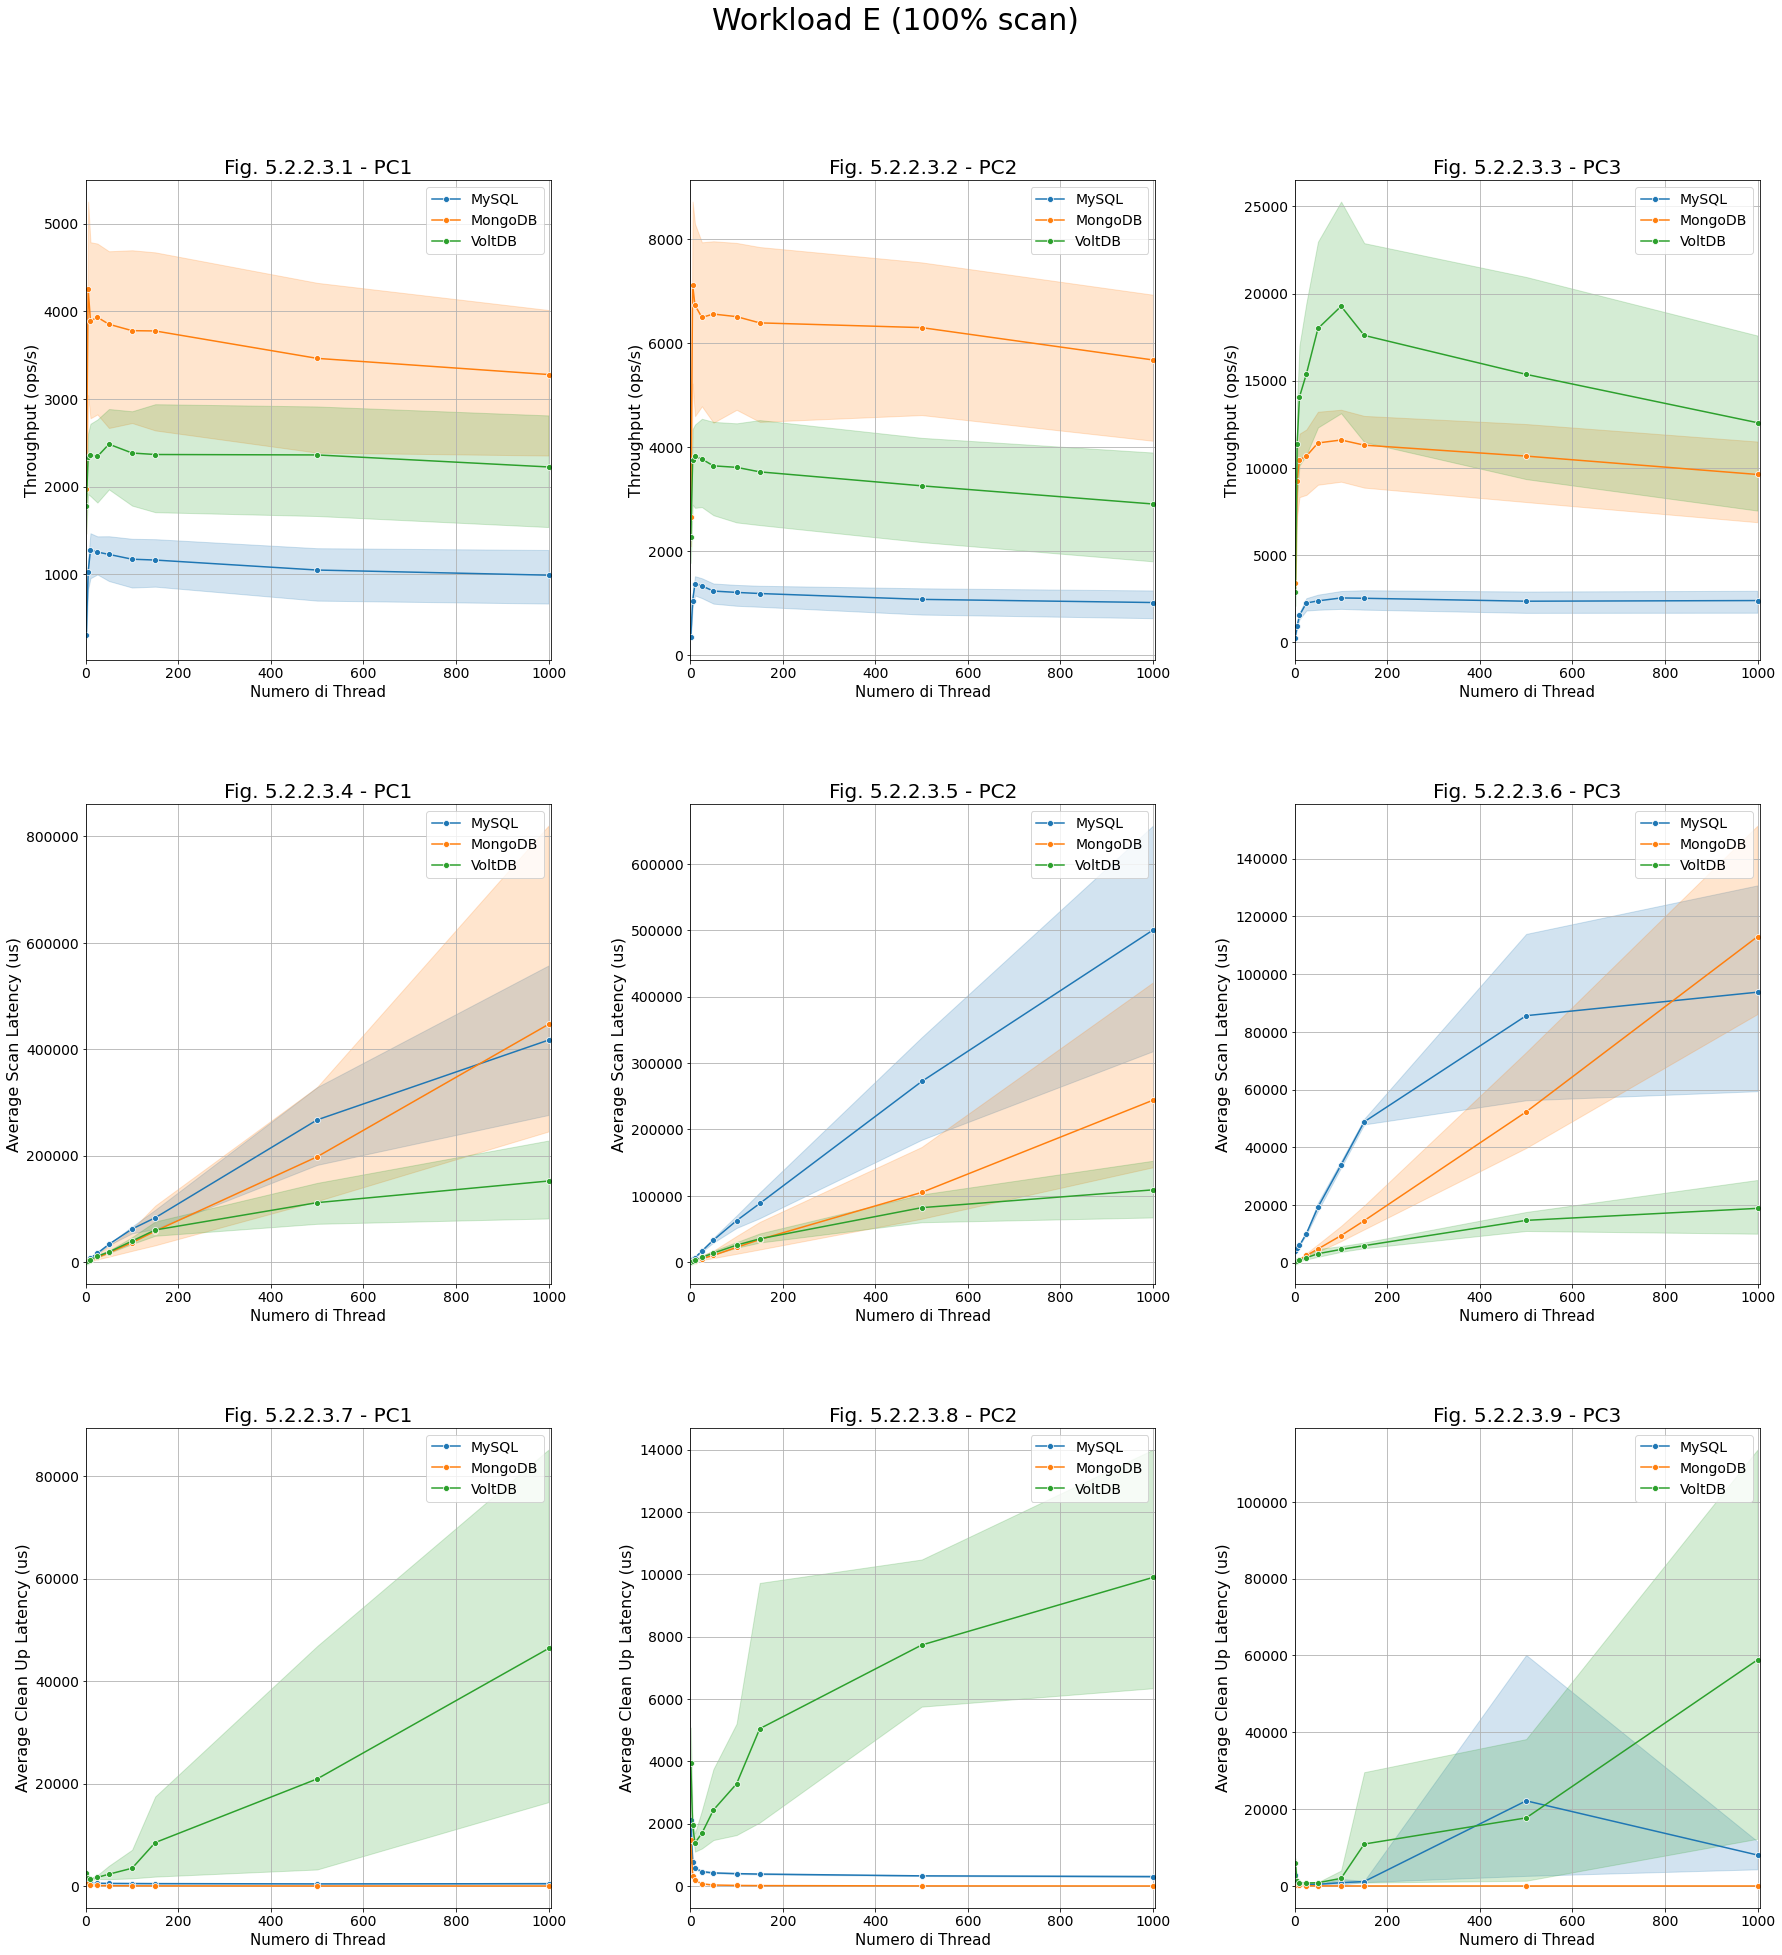

In [19]:
fig=plt.figure(figsize=(30, 30))
fig.suptitle('Workload E (100% scan)', fontsize=30)
plt.subplots_adjust(top=0.9, bottom=0.1, wspace=0.3, hspace=0.3)


parametri = ['Throughput (ops/s)', 'Average Scan Latency (us)', 'Average Clean Up Latency (us)']
memoria = [12, 16, 32]
computer = ['PC1', 'PC2', 'PC3']

n_graph = 1

for param in parametri:
    pccount=0
    for ram_dim in memoria:
        x = df['Numero di Thread']
        if ram_dim == 12:
            y = df.loc[((df['Database']=='MySQL (new)') & (df['Tipo di Workload']=='e') & (df['Dimensione RAM (GB)']==ram_dim)), param]
            y2 = df.loc[((df['Database']=='MongoDB (new)') & (df['Tipo di Workload']=='e') & (df['Dimensione RAM (GB)']==ram_dim)), param]            
        else:
            y = df.loc[((df['Database']=='MySQL') & (df['Tipo di Workload']=='e') & (df['Dimensione RAM (GB)']==ram_dim)), param]
            y2 = df.loc[((df['Database']=='MongoDB') & (df['Tipo di Workload']=='e') & (df['Dimensione RAM (GB)']==ram_dim)), param]
        y3 = df.loc[((df['Database']=='VoltDB') & (df['Tipo di Workload']=='e') & (df['Dimensione RAM (GB)']==ram_dim)), param]
        ax = fig.add_subplot(3, 3, n_graph)
        sns.lineplot (x, y, label = 'MySQL', marker = 'o', ax=ax)
        sns.lineplot (x, y2, label = 'MongoDB', marker = 'o', ax=ax)
        sns.lineplot (x, y3, label = 'VoltDB', marker = 'o', ax=ax)
        ax = plt.gca()
        ax.set_xlim(0, 1005)
        new_title = 'Fig. 5.2.2.3.' + str(n_graph) +' - ' + computer[pccount]
        ax.set_title(new_title, fontsize=20)
        ax.set_xlabel('Numero di Thread', fontsize=15)
        ax.set_ylabel(param, fontsize=16)
        plt.setp(ax.get_xticklabels(), fontsize=14)
        plt.setp(ax.get_yticklabels(), fontsize=14)
        ax.grid()
        ax.legend(prop={'size': 14})
        n_graph+=1
        pccount+=1
plt.show()

#### MySQL Tuned

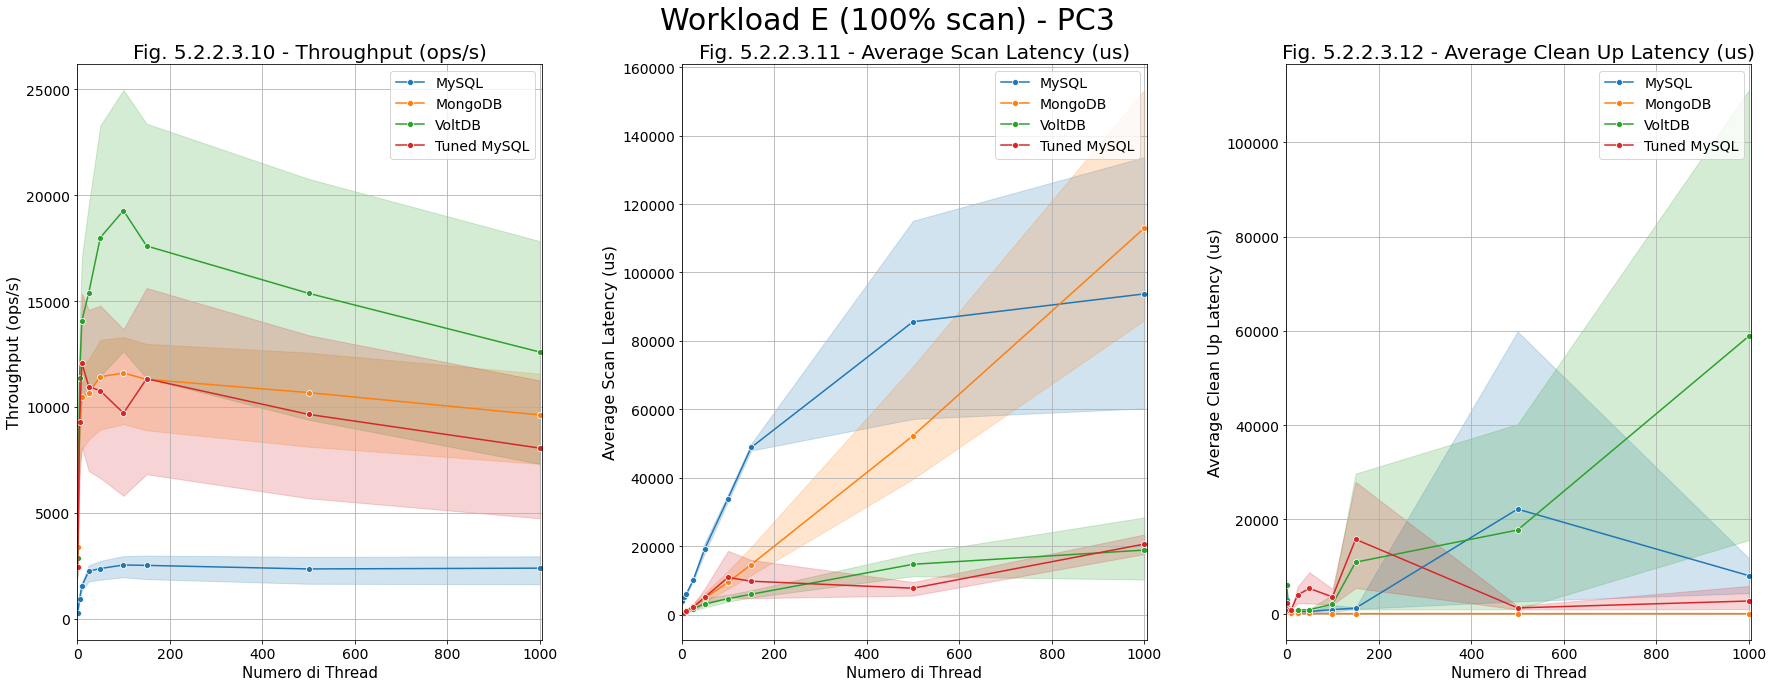

In [ ]:
# Throughhput per numero di operazioni con 10 threads
fig=plt.figure(figsize=(30, 10))
fig.suptitle('Workload E (100% scan) - PC3', fontsize=30)
plt.subplots_adjust(top=0.9, bottom=0.1, wspace=0.3, hspace=0.3)


parametri = ['Throughput (ops/s)', 'Average Scan Latency (us)', 'Average Clean Up Latency (us)']

n_graph = 1
for param in parametri:
    x = df['Numero di Thread']
    y = df.loc[((df['Database']=='MySQL') & (df['Tipo di Workload']=='e') & (df['Dimensione RAM (GB)']==32)), param]
    y2 = df.loc[((df['Database']=='MongoDB') & (df['Tipo di Workload']=='e') & (df['Dimensione RAM (GB)']==32)), param]
    y3 = df.loc[((df['Database']=='VoltDB') & (df['Tipo di Workload']=='e') & (df['Dimensione RAM (GB)']==32)), param]
    y4 = df.loc[((df['Database']=='MySQL (tuned)') & (df['Tipo di Workload']=='e') & (df['Dimensione RAM (GB)']==32)), param]

    ax = fig.add_subplot(1, 3, n_graph)
    sns.lineplot (x, y, label = 'MySQL', marker = 'o', ax=ax)
    sns.lineplot (x, y2, label = 'MongoDB', marker = 'o', ax=ax)
    sns.lineplot (x, y3, label = 'VoltDB', marker = 'o', ax=ax)
    sns.lineplot (x, y4, label = 'Tuned MySQL', marker = 'o', ax=ax)

    ax = plt.gca()
    ax.set_xlim(0, 1005)
    new_title = 'Fig. 5.2.2.3.' + str(9+n_graph) +' - ' + param
    ax.set_title(new_title, fontsize=20)
    ax.set_xlabel('Numero di Thread', fontsize=15)
    ax.set_ylabel(param, fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=14)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    ax.grid()
    ax.legend(prop={'size': 14})
    n_graph+=1
plt.show()

# Update Fail

### Totali

Text(0.5, 1.0, 'Numero di Update falliti totali per ogni DB')

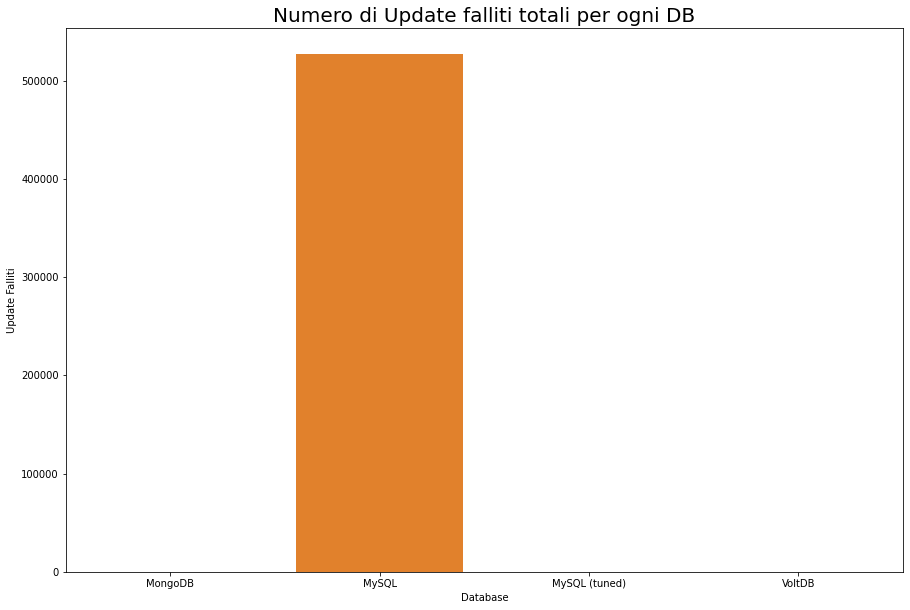

In [18]:
# Somma di tutti gli update falliti per ogni MySQL
df_update=df.loc[((df.Database!='MySQL (new)') & (df.Database!='MongoDB (new)'))].groupby(df.Database).agg({'Update Falliti':'sum'})

# Grafico
plt.figure(figsize=(15,10))
ax = sns.barplot(df_update.index, df_update['Update Falliti'])
ax.set_title('Numero di Update falliti totali per ogni DB', fontsize=20)

Text(0.5, 0, 'Wokload')

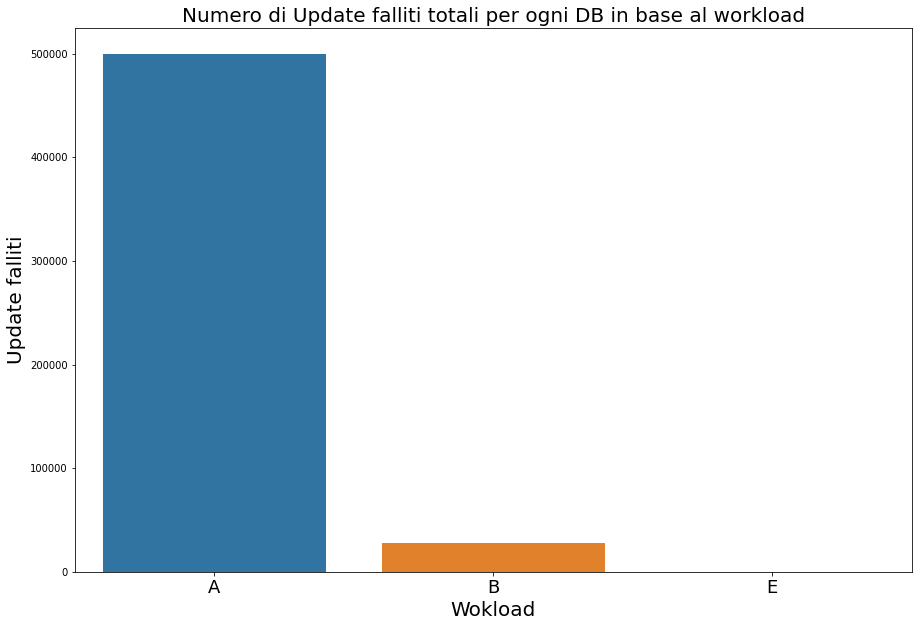

In [16]:
# Somma degli update falliti per ogni workload
df_update=df.loc[((df.Database!='MySQL (new)') & (df.Database!='MongoDB (new)'))].groupby(df['Tipo di Workload']).agg({'Update Falliti':'sum'})

# Grafico
plt.figure(figsize=(15,10))
ax = sns.barplot(df_update.index, df_update['Update Falliti'])
ax.set_title('Numero di Update falliti totali per ogni DB in base al workload', fontsize=20)
ax.set_xticklabels(['A', 'B', 'E'], fontsize=18)

ax.set_ylabel("Update falliti", fontsize=20)
ax.set_xlabel("Wokload", fontsize=20)

###  In base al nr di operazioni

Text(0.5, 0, 'Numero di query per computer utilizzato')

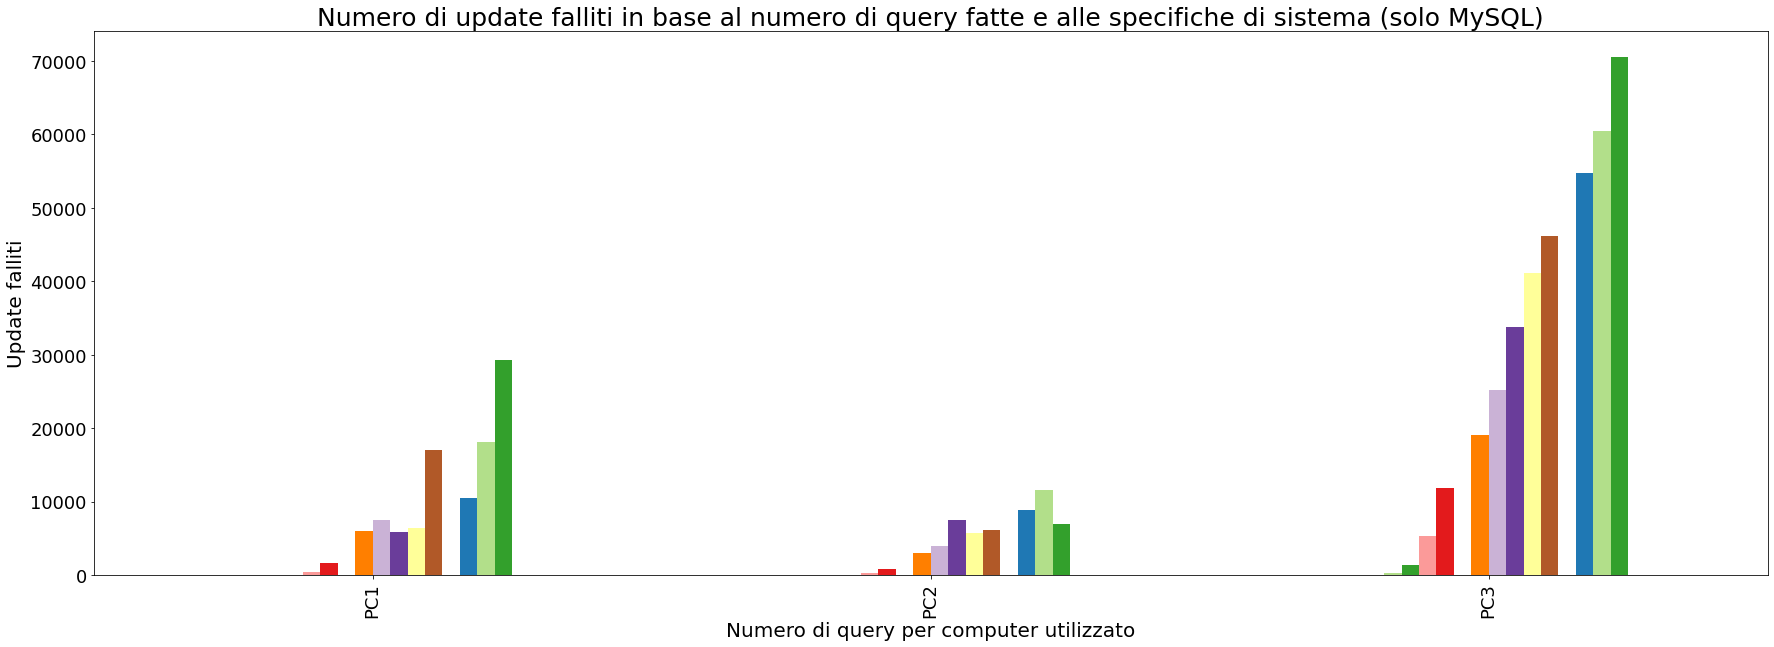

In [ ]:
# Somma degli update falliti in base al numero di query e in base al DB
df_update_nOp=df.loc[df.Database=='MySQL'].groupby([df.Database, df['Dimensione RAM (GB)'], df['Numero di Query']]).agg({'Update Falliti':'sum'})

# Grafico
ax = df_update_nOp.unstack(-1).plot(kind='bar', figsize=(30,10), legend = False, color=sns.color_palette('Paired'), fontsize=18)
ax.set_title('Numero di update falliti in base al numero di query fatte e alle specifiche di sistema (solo MySQL)', fontsize=25)
ax.set_xticklabels(['PC1', 'PC2', 'PC3'], fontsize=18)
ax.set_ylabel("Update falliti", fontsize=20)
ax.set_xlabel("Numero di query per computer utilizzato", fontsize=20)

### In base al numero di thread

Text(0.5, 0, 'Numero di thread per computer utilizzato')

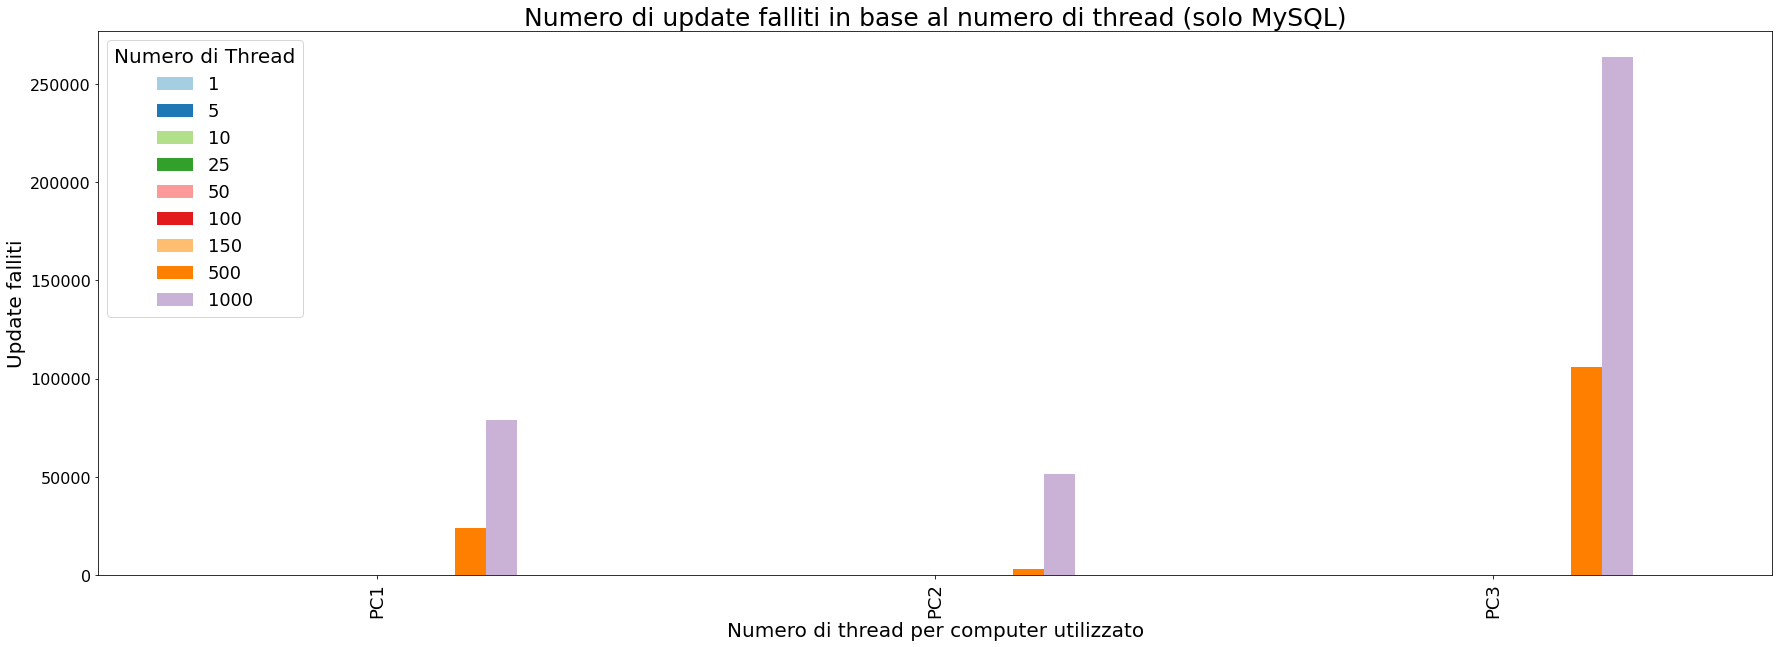

In [ ]:
# Somma degli update falliti in base al numero di thread e in base al DB
df_update_nT=df.loc[df.Database=='MySQL'].groupby([df.Database,  df['Dimensione RAM (GB)'], df['Numero di Thread']]).agg({'Update Falliti':'sum'})

# Grafico
ax = df_update_nT.unstack(-1).plot(kind='bar', figsize=(30,10), legend = True, color=sns.color_palette('Paired') , fontsize=16)
ax.legend(title='Numero di Thread', labels=['1', '5', '10', '25', '50', '100', '150','500', '1000'], fontsize=18, title_fontsize=20)
ax.set_title('Numero di update falliti in base al numero di thread (solo MySQL)', fontsize=25)
ax.set_ylabel("Update falliti", fontsize=20)
ax.set_xticklabels(['PC1', 'PC2', 'PC3'], fontsize=18)
ax.set_xlabel("Numero di thread per computer utilizzato", fontsize=20)